![qqq](../resources/header.jpg)

**Машинное обучение**
***

О сайте **VGChartz.com**:

"Компания **VGChartz (Video Game Charts)**, основанная в 2005 году Бреттом Уолтоном, является фирмой по бизнес-аналитике и исследованиям, а также издателем веб-сайтов **VGChartz.com**. Как отраслевая исследовательская фирма, VGChartz каждую неделю публикует оценки оборудования для видеоигр и размещает постоянно расширяющуюся базу данных игр, в которой содержится более 55 000 наименований, содержащая актуальную информацию о поставках и устаревшие данные о продажах. Веб-сайт VGChartz.com предоставляет потребителям разнообразный контент: от новостей и продаж до обзоров и статей, социальных сетей и форумов сообщества". - с сайта **[VGChartz.com](https://www.vgchartz.com)**.

**Методология сбора данных**:
С конца 2018 года VGChartz больше не составляет оценки продаж программного обеспечения. Это связано с тем, что высокая доля цифрового рынка программного обеспечения затрудняла получение надежных розничных оценок, а также делала эти оценки все более нерепрезентативными для более широкой производительности рассматриваемых игр. В результате, что касается программного обеспечения, мы теперь записываем только официальные данные об отгрузках/продажах, если такие данные предоставляются разработчиками и издателями. Устаревшие данные остаются на сайте для тех, кто заинтересован в их просмотре.- с сайта **[VGChartz.com](https://www.vgchartz.com)**.

**Цель машинного обучения**: на основе подготовленных и предварительно обработанных исторических данных, обучить модель, предсказывающую количество проданных копий видеоигры.

**Этапы машинного обучения**:
1. [Обзор данных](#Обзор-данных).
2. [Предобработка данных](#Предобработка-данных)
3. [Машинное обучение](#Машинное-обучение):
    - [Отбор данных](#Отбор-данных);
    - [Преобразование данных](#Преобразование-данных);
    - [Разделение на выборки](#Разделение-на-выборки)
    - [Тестирование моделей](#Тестирование-моделей)
        - [Тестирование DecisionTreeRegressor](#Тестирование-DecisionTreeRegressor)
        - [Тестирование RandomForestRegressor](#Тестирование-RandomForestRegressor)
        - [Тестирование HistGradientBoostingRegressor](#Тестирование-HistGradientBoostingRegressor)
        - [Тестирование LGBMRegressor](#Тестирование-LGBMRegressor)
        - [Тестирование XGBRegressor](#Тестирование-XGBRegressor)
        - [Выводы по тестированию моделей](#Выводы-по-тестированию-моделей)
    - [Генерация признаков](#Генерация-признаков)
        - [DecisionTreeRegressor](#DecisionTreeRegressor)
        - [RandomForestRegressor](#RandomForestRegressor)
        - [HistGradientBoostingRegressor](#HistGradientBoostingRegressor)
        - [LGBMRegressor](#LGBMRegressor)
        - [XGBRegressor](#XGBRegressor)
        - [Выводы по генерации признаков](#Выводы-по-генерации-признаков)
    - [Проверка модели на тестовой выборке](#Проверка-модели-на-тестовой-выборке).
    - [Сравнение с фиктивным регрессором](#Сравнение-с-фиктивным-регрессором).
4. [Выводы](#Выводы)
***

In [1]:
import sys

In [2]:
sys.path.append('C:\Projects\VGChartz\src')

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import TargetEncoder
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from config.ml import CV_N_SPLITS
from config.ml import CV_TEST_SIZE
from config.ml import CV_TRAIN_SIZE
from config.ml import CV_VERBOSE
from config.ml import LEARNING_CURVE_TRAIN_SIZES
from config.ml import N_JOBS
from config.ml import RANDOM_STATE
from config.ml import TEST_SIZE
from config.paths import FILE_PREPROCESSED_PATH
from utils import plot
from utils.explorer import explorer

In [4]:
sns.set_style('white')

In [5]:
print(explorer(FILE_PREPROCESSED_PATH, '*.csv'))

1. vgchartz.csv.


In [6]:
FILE_PATH = FILE_PREPROCESSED_PATH + r'\vgchartz.csv'

# Обзор данных
***

In [7]:
df = pd.read_csv(FILE_PATH)

In [8]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15527 entries, 0 to 15526
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   platform   15527 non-null  object 
 1   publisher  15527 non-null  object 
 2   developer  15527 non-null  object 
 3   america    15527 non-null  bool   
 4   europe     15527 non-null  bool   
 5   japan      15527 non-null  bool   
 6   other      15527 non-null  bool   
 7   total      15527 non-null  float64
dtypes: bool(4), float64(1), object(3)
memory usage: 3.1 MB


In [9]:
df.head()

,platform,publisher,developer,america,europe,japan,other,total
0,PC,505 Games,BiArt Studios,False,False,False,False,0.01
1,PC,Paradox Interactive,Most Wanted Entertainment,False,True,False,False,0.01
2,2600,Atari,Atari,True,True,False,True,0.98
3,2600,Atari,Atari,True,True,False,False,0.27
4,2600,Atari,Atari,True,True,False,False,0.44


In [10]:
df.sample(5)

,platform,publisher,developer,america,europe,japan,other,total
6378,PSP,Prototype,Prototype,False,False,True,False,0.02
2994,GBA,Natsume,"Imagineer Co., Ltd.",True,True,False,False,0.05
14464,PS4,Xseed Games,Acquire,True,False,True,True,0.08
15511,NS,Square Enix,Square Enix,False,False,True,False,0.14
2651,XB,Infogrames,Runecraft,True,True,False,True,0.18


In [11]:
df.tail()

,platform,publisher,developer,america,europe,japan,other,total
15522,PS4,NIS America,Falcom,False,False,True,False,0.13
15523,PS3,Sony Computer Entertainment,PlayStation C.A.M.P.!,False,False,True,False,0.26
15524,DS,Ubisoft,Global A Entertainment,True,False,False,True,0.29
15525,PS4,GungHo,Grasshopper Manufacture,False,True,True,False,0.01
15526,3DS,Namco Bandai Games,Namco Bandai Games,False,False,True,False,0.01


# Машинное обучение
***

## Разделение на выборки
***

In [12]:
x = df.drop('total', axis=1)
y = df['total']

In [13]:
x

,platform,publisher,developer,america,europe,japan,other
0,PC,505 Games,BiArt Studios,False,False,False,False
1,PC,Paradox Interactive,Most Wanted Entertainment,False,True,False,False
2,2600,Atari,Atari,True,True,False,True
3,2600,Atari,Atari,True,True,False,False
4,2600,Atari,Atari,True,True,False,False
...,...,...,...,...,...,...,...
15522,PS4,NIS America,Falcom,False,False,True,False
15523,PS3,Sony Computer Entertainment,PlayStation C.A.M.P.!,False,False,True,False
15524,DS,Ubisoft,Global A Entertainment,True,False,False,True
15525,PS4,GungHo,Grasshopper Manufacture,False,True,True,False


In [14]:
y

0        0.01
1        0.01
2        0.98
3        0.27
4        0.44
         ... 
15522    0.13
15523    0.26
15524    0.29
15525    0.01
15526    0.01
Name: total, Length: 15527, dtype: float64

In [15]:
x_train, x_test, y_train, y_test = train_test_split(
    x, 
    y,
    shuffle=False, 
    test_size=TEST_SIZE * 2,
    random_state=RANDOM_STATE
)

In [16]:
x_valid, x_test, y_valid, y_test = train_test_split(
    x_test, 
    y_test,
    shuffle=False, 
    test_size=0.5,
    random_state=RANDOM_STATE
)

In [17]:
x_train

,platform,publisher,developer,america,europe,japan,other
0,PC,505 Games,BiArt Studios,False,False,False,False
1,PC,Paradox Interactive,Most Wanted Entertainment,False,True,False,False
2,2600,Atari,Atari,True,True,False,True
3,2600,Atari,Atari,True,True,False,False
4,2600,Atari,Atari,True,True,False,False
...,...,...,...,...,...,...,...
15122,XOne,THQ Nordic,Volition,True,True,False,False
15123,PS4,Frontier Developments,Frontier Developments,True,True,False,True
15124,PS4,THQ Nordic,Volition,True,True,False,True
15125,PS4,Ubisoft,Ubisoft Montreal,False,False,True,False


In [18]:
x_valid

,platform,publisher,developer,america,europe,japan,other
15127,NS,Bigben Interactive,Breakpoint Studio,True,False,False,False
15128,NS,Outright Games,Torus Games,True,False,False,False
15129,XOne,Sega,Media.Vision,True,False,False,False
15130,NS,Sega,Media.Vision,True,True,True,True
15131,PS4,Sega,Media.Vision,True,True,True,True
...,...,...,...,...,...,...,...
15322,NS,GameMill Entertainment,"Concrete Software, Inc.",True,False,False,False
15323,NS,Rising Star,Zoink Games,True,False,False,False
15324,XOne,Koei Tecmo,Omega Force,True,False,False,False
15325,PS4,2K Games,Saber Interactive,True,False,False,True


In [19]:
x_test

,platform,publisher,developer,america,europe,japan,other
15327,XOne,Ubisoft,Ubisoft Toronto,True,False,False,True
15328,NS,GameMill Entertainment,Play Mechanix,True,False,False,False
15329,NS,Warner Bros. Interactive Entertainment,Traveller's Tales,True,True,False,True
15330,NS,Merge Games,Teku Studios,True,False,False,False
15331,PS4,Warner Bros. Interactive Entertainment,Traveller's Tales,True,True,False,True
...,...,...,...,...,...,...,...
15522,PS4,NIS America,Falcom,False,False,True,False
15523,PS3,Sony Computer Entertainment,PlayStation C.A.M.P.!,False,False,True,False
15524,DS,Ubisoft,Global A Entertainment,True,False,False,True
15525,PS4,GungHo,Grasshopper Manufacture,False,True,True,False


In [20]:
pd.DataFrame(
    data={
        'X': [x_train.shape, x_valid.shape, x_test.shape],
        'Y': [y_train.shape, y_valid.shape, y_test.shape],
    },
    index=['train', 'valid', 'test']
)

,X,Y
train,"(15127, 7)","(15127,)"
valid,"(200, 7)","(200,)"
test,"(200, 7)","(200,)"


## Тестирование моделей
***

In [21]:
index = [
    'DecisionTreeRegressor', 
    'RandomForestRegressor', 
    'HistGradientBoostingRegressor', 
    'LGBMRegressor', 
    'XGBRegressor'
]
columns = ['Время обучения', 'Время предсказания', 'RMSE']
results = pd.DataFrame(
    columns=columns,
    index=index
)
results.style.format(na_rep='-')

,Время обучения,Время предсказания,RMSE
DecisionTreeRegressor,-,-,-
RandomForestRegressor,-,-,-
HistGradientBoostingRegressor,-,-,-
LGBMRegressor,-,-,-
XGBRegressor,-,-,-


In [22]:
category = [
    'platform', 
    'publisher', 
    'developer', 
    'america', 
    'europe', 
    'japan', 
    'other'
]
encoder = TargetEncoder(
    random_state=RANDOM_STATE
)

standardizer = ColumnTransformer(
     transformers=[
            ('encoder', encoder, category)
        ],
    remainder='passthrough'
)

standardizer

ColumnTransformer(remainder='passthrough',
                  transformers=[('encoder', TargetEncoder(random_state=42),
                                 ['platform', 'publisher', 'developer',
                                  'america', 'europe', 'japan', 'other'])])

In [23]:
cv = TimeSeriesSplit(
    n_splits=CV_N_SPLITS,
    max_train_size=CV_TRAIN_SIZE,
    test_size=CV_TEST_SIZE
)

In [24]:
scoring = 'neg_root_mean_squared_error'

### Тестирование DecisionTreeRegressor

In [25]:
estimator = DecisionTreeRegressor(random_state=RANDOM_STATE)
model = Pipeline(
    steps=[
        ('standardizer', standardizer),
        ('estimator', estimator),
    ]
)
model

Pipeline(steps=[('standardizer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  TargetEncoder(random_state=42),
                                                  ['platform', 'publisher',
                                                   'developer', 'america',
                                                   'europe', 'japan',
                                                   'other'])])),
                ('estimator', DecisionTreeRegressor(random_state=42))])

In [26]:
param_grid = {
    'estimator__max_depth': np.arange(2, 21),
    'estimator__min_samples_split': np.arange(2, 21)
}

In [27]:
dt_rgs = RandomizedSearchCV(
    estimator=model,
    n_iter=10,
    cv=cv,
    scoring=scoring,
    param_distributions=param_grid,
    verbose=CV_VERBOSE
)

dt_rgs.fit(x_train, y_train);

Fitting 15 folds for each of 10 candidates, totalling 150 fits
[CV 1/15] END estimator__max_depth=19, estimator__min_samples_split=5;, score=-0.243 total time=   0.0s
[CV 2/15] END estimator__max_depth=19, estimator__min_samples_split=5;, score=-0.249 total time=   0.0s
[CV 3/15] END estimator__max_depth=19, estimator__min_samples_split=5;, score=-0.221 total time=   0.0s
[CV 4/15] END estimator__max_depth=19, estimator__min_samples_split=5;, score=-0.244 total time=   0.0s
[CV 5/15] END estimator__max_depth=19, estimator__min_samples_split=5;, score=-0.207 total time=   0.0s
[CV 6/15] END estimator__max_depth=19, estimator__min_samples_split=5;, score=-0.258 total time=   0.0s
[CV 7/15] END estimator__max_depth=19, estimator__min_samples_split=5;, score=-0.192 total time=   0.0s
[CV 8/15] END estimator__max_depth=19, estimator__min_samples_split=5;, score=-0.231 total time=   0.0s
[CV 9/15] END estimator__max_depth=19, estimator__min_samples_split=5;, score=-0.182 total time=   0.0s
[

In [28]:
cv_results = pd.DataFrame(
    data=dt_rgs.cv_results_, 
).sort_values('rank_test_score')
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__min_samples_split,param_estimator__max_depth,params,split0_test_score,split1_test_score,split2_test_score,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
2,0.025083,0.005891,0.008662,0.002241,20,5,"{'estimator__min_samples_split': 20, 'estimato...",-0.198555,-0.190398,-0.157528,...,-0.140765,-0.152193,-0.153020,-0.141077,-0.140916,-0.150782,-0.104761,-0.160952,0.027838,1
1,0.026447,0.004060,0.008002,0.003868,17,5,"{'estimator__min_samples_split': 17, 'estimato...",-0.198555,-0.190333,-0.157528,...,-0.140765,-0.152193,-0.153020,-0.141077,-0.145949,-0.150782,-0.104761,-0.161294,0.027627,2
6,0.025220,0.005103,0.009014,0.004910,15,5,"{'estimator__min_samples_split': 15, 'estimato...",-0.198555,-0.190317,-0.157528,...,-0.141283,-0.152193,-0.153020,-0.141077,-0.145949,-0.150782,-0.104761,-0.161316,0.027597,3
3,0.027871,0.005154,0.008820,0.003375,10,7,"{'estimator__min_samples_split': 10, 'estimato...",-0.205344,-0.201815,-0.172286,...,-0.143400,-0.148275,-0.161063,-0.136768,-0.147824,-0.144854,-0.108032,-0.165173,0.030732,4
9,0.028518,0.004343,0.007633,0.002858,10,9,"{'estimator__min_samples_split': 10, 'estimato...",-0.218968,-0.213305,-0.193221,...,-0.154139,-0.162833,-0.176545,-0.141490,-0.146289,-0.161284,-0.115072,-0.177395,0.031706,5


In [29]:
results.loc['DecisionTreeRegressor', 'Время обучения'] = cv_results.iloc[0, 0]
results.loc['DecisionTreeRegressor', 'Время предсказания'] = cv_results.iloc[0, 2]
results.loc['DecisionTreeRegressor', 'RMSE'] = cv_results.iloc[0, -3]

In [30]:
(train_sizes,
 train_scores, test_scores,
 fit_times, score_times) = learning_curve(
    estimator=dt_rgs.best_estimator_,
    X=x_train,
    y=y_train,
    train_sizes=LEARNING_CURVE_TRAIN_SIZES,
    cv=cv,
    n_jobs=N_JOBS,
    scoring='neg_root_mean_squared_error',
    return_times=True,
    verbose=CV_VERBOSE
)

[learning_curve] Training set sizes: [  20  100  400  800 1200 1600 2000]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  34 out of 105 | elapsed:    3.2s remaining:    6.8s
[Parallel(n_jobs=4)]: Done  70 out of 105 | elapsed:    3.7s remaining:    1.8s
[Parallel(n_jobs=4)]: Done 105 out of 105 | elapsed:    4.2s finished


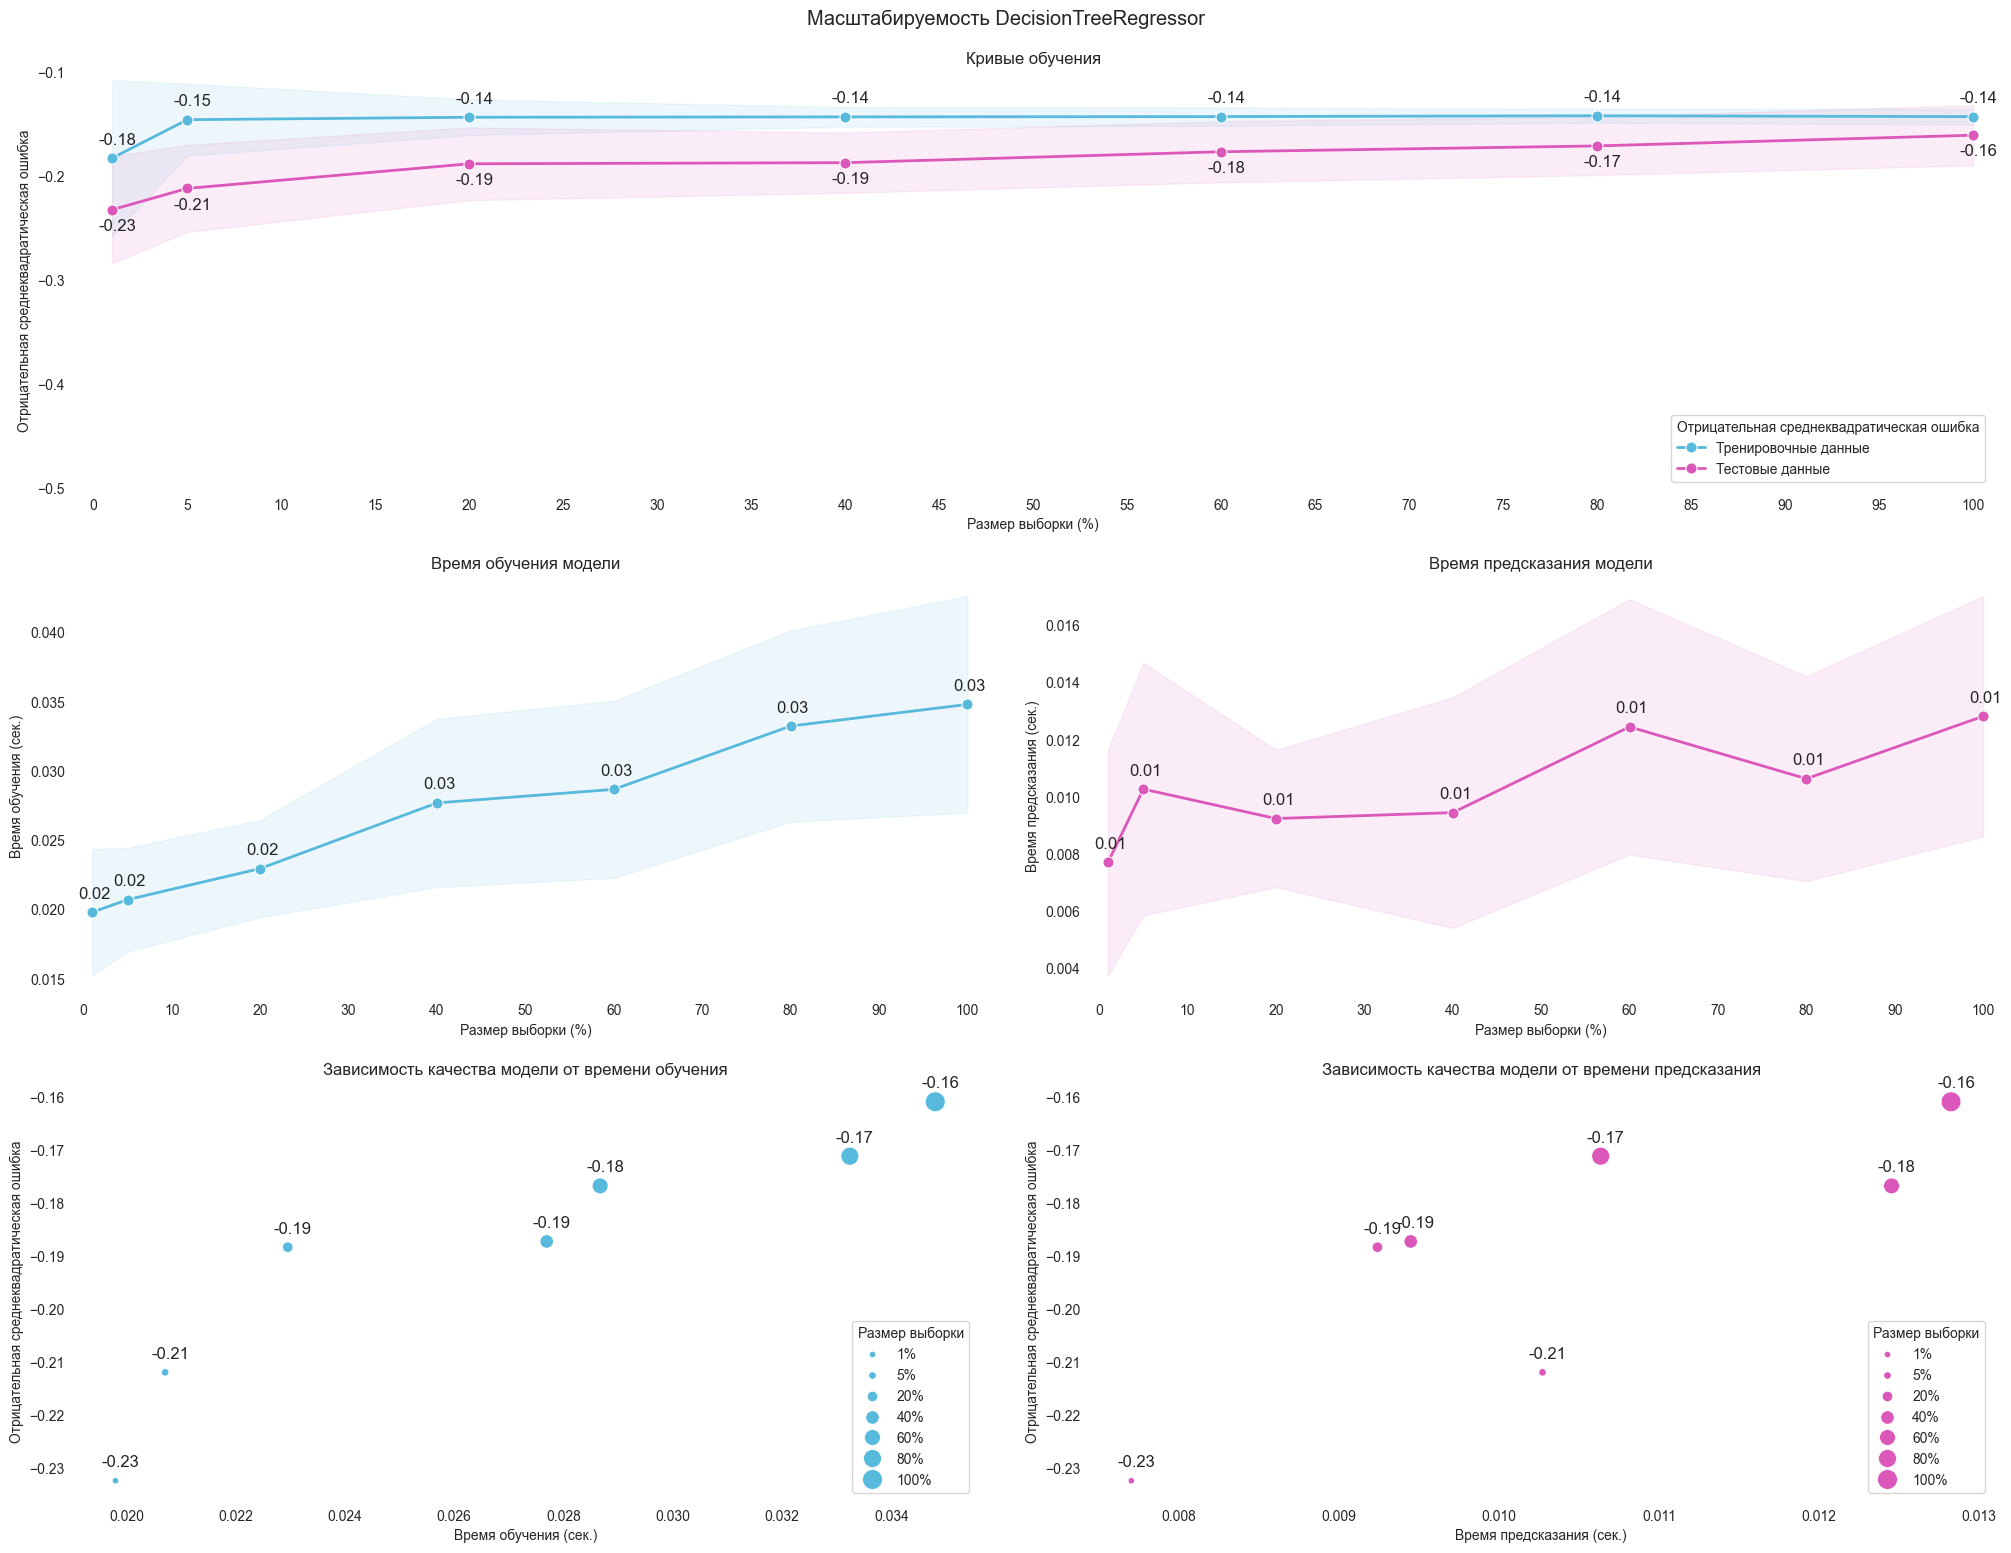

In [31]:
x_train_size = CV_TRAIN_SIZE
plot.scalability(
    train_sizes=pd.Series((train_sizes / x_train_size * 100).round(1)),
    train_scores=pd.DataFrame(train_scores),
    test_scores=pd.DataFrame(test_scores),
    fit_times=pd.DataFrame(fit_times),
    score_times=pd.DataFrame(score_times),
    title=f'Масштабируемость DecisionTreeRegressor'
)

In [32]:
predict = dt_rgs.predict(x_valid)

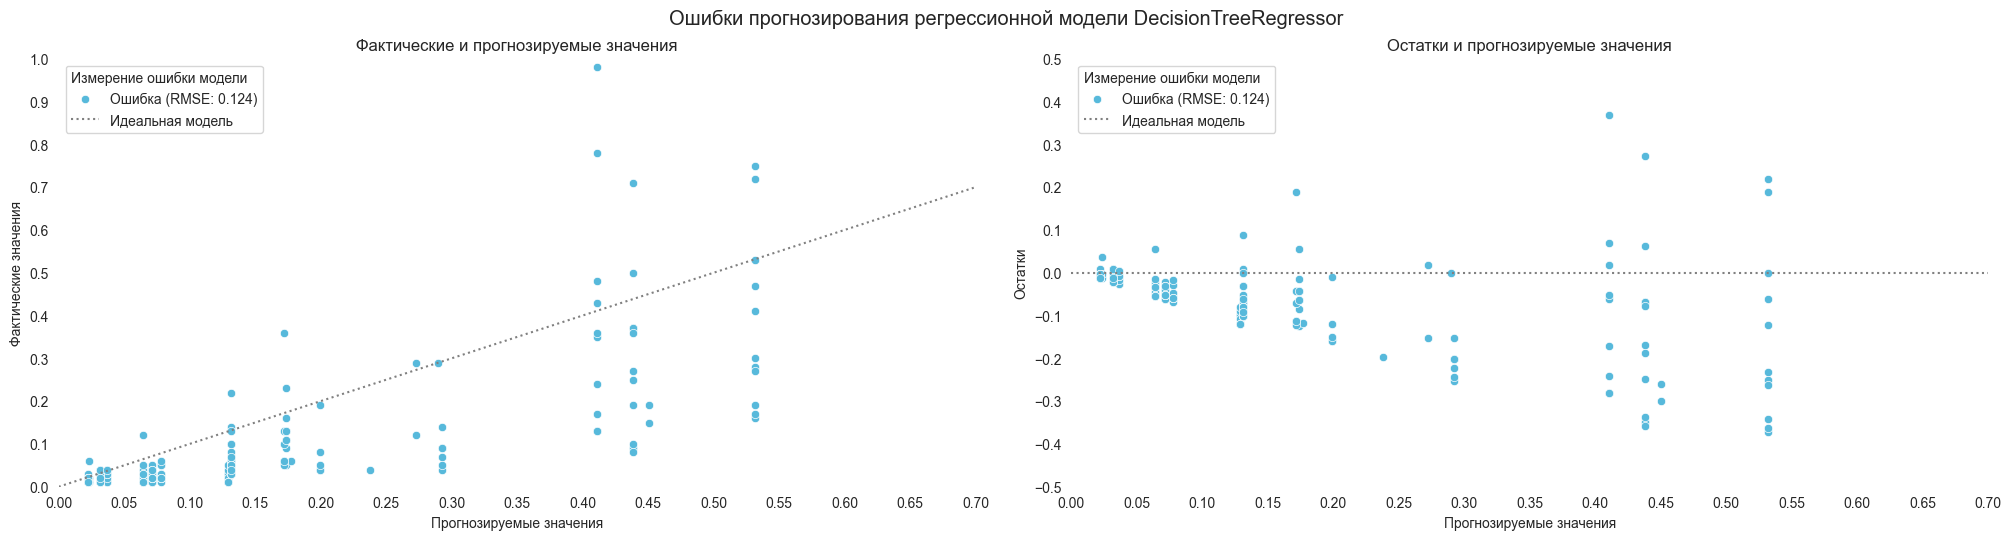

In [33]:
plot.error(
    y_true=pd.Series(y_valid), 
    y_predict=pd.Series(predict),
    title='Ошибки прогнозирования регрессионной модели DecisionTreeRegressor'
)

### Тестирование RandomForestRegressor

In [34]:
estimator = RandomForestRegressor(random_state=RANDOM_STATE)
model = Pipeline(
    steps=[
        ('standardizer', standardizer),
        ('estimator', estimator),
    ]
)
model

Pipeline(steps=[('standardizer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  TargetEncoder(random_state=42),
                                                  ['platform', 'publisher',
                                                   'developer', 'america',
                                                   'europe', 'japan',
                                                   'other'])])),
                ('estimator', RandomForestRegressor(random_state=42))])

In [35]:
param_grid = {
    'estimator__n_estimators': np.arange(150, 451, 150),
    'estimator__max_depth': np.arange(4, 13, 4),
    'estimator__min_samples_split': np.arange(2, 11, 4),
    'estimator__min_samples_leaf': np.arange(1, 10, 4)
}

In [36]:
rf_rgs = RandomizedSearchCV(
    estimator=model,
    n_iter=10,
    cv=cv,
    scoring=scoring,
    param_distributions=param_grid,
    verbose=CV_VERBOSE
)
rf_rgs.fit(x_train, y_train);

Fitting 15 folds for each of 10 candidates, totalling 150 fits
[CV 1/15] END estimator__max_depth=4, estimator__min_samples_leaf=9, estimator__min_samples_split=2, estimator__n_estimators=150;, score=-0.197 total time=   0.5s
[CV 2/15] END estimator__max_depth=4, estimator__min_samples_leaf=9, estimator__min_samples_split=2, estimator__n_estimators=150;, score=-0.187 total time=   0.5s
[CV 3/15] END estimator__max_depth=4, estimator__min_samples_leaf=9, estimator__min_samples_split=2, estimator__n_estimators=150;, score=-0.146 total time=   0.5s
[CV 4/15] END estimator__max_depth=4, estimator__min_samples_leaf=9, estimator__min_samples_split=2, estimator__n_estimators=150;, score=-0.198 total time=   0.6s
[CV 5/15] END estimator__max_depth=4, estimator__min_samples_leaf=9, estimator__min_samples_split=2, estimator__n_estimators=150;, score=-0.143 total time=   0.5s
[CV 6/15] END estimator__max_depth=4, estimator__min_samples_leaf=9, estimator__min_samples_split=2, estimator__n_estimato

In [37]:
cv_results = pd.DataFrame(
    data=rf_rgs.cv_results_, 
).sort_values('rank_test_score')
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__n_estimators,param_estimator__min_samples_split,param_estimator__min_samples_leaf,param_estimator__max_depth,params,split0_test_score,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
7,2.761753,0.064963,0.057065,0.007446,450,10,5,8,"{'estimator__n_estimators': 450, 'estimator__m...",-0.197135,...,-0.133564,-0.144618,-0.145379,-0.132615,-0.134241,-0.135379,-0.105058,-0.153003,0.026634,1
5,1.841308,0.026030,0.039405,0.002702,300,10,5,8,"{'estimator__n_estimators': 300, 'estimator__m...",-0.197106,...,-0.134036,-0.145308,-0.145450,-0.132482,-0.134165,-0.135050,-0.104959,-0.153079,0.026666,2
9,1.926248,0.152066,0.040239,0.006813,300,10,9,12,"{'estimator__n_estimators': 300, 'estimator__m...",-0.197260,...,-0.136060,-0.147185,-0.144361,-0.132117,-0.135856,-0.136090,-0.106174,-0.153597,0.026148,3
4,1.066000,0.155563,0.030333,0.008830,150,10,9,12,"{'estimator__n_estimators': 150, 'estimator__m...",-0.197773,...,-0.136820,-0.144975,-0.144412,-0.132335,-0.136597,-0.135996,-0.105901,-0.153708,0.026170,4
2,1.219849,0.027475,0.027538,0.003943,150,10,1,12,"{'estimator__n_estimators': 150, 'estimator__m...",-0.199339,...,-0.138053,-0.146557,-0.151632,-0.132692,-0.132497,-0.135724,-0.104496,-0.155165,0.027400,5


In [38]:
results.loc['RandomForestRegressor', 'Время обучения'] = cv_results.iloc[0, 0]
results.loc['RandomForestRegressor', 'Время предсказания'] = cv_results.iloc[0, 2]
results.loc['RandomForestRegressor', 'RMSE'] = cv_results.iloc[0, -3]

In [39]:
(train_sizes,
 train_scores, test_scores,
 fit_times, score_times) = learning_curve(
    estimator=rf_rgs.best_estimator_,
    X=x_train,
    y=y_train,
    train_sizes=LEARNING_CURVE_TRAIN_SIZES,
    cv=cv,
    n_jobs=N_JOBS,
    scoring='neg_root_mean_squared_error',
    return_times=True,
    verbose=CV_VERBOSE
)

[learning_curve] Training set sizes: [  20  100  400  800 1200 1600 2000]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  34 out of 105 | elapsed:   20.3s remaining:   42.5s
[Parallel(n_jobs=4)]: Done  70 out of 105 | elapsed:   41.8s remaining:   20.8s
[Parallel(n_jobs=4)]: Done 105 out of 105 | elapsed:  1.0min finished


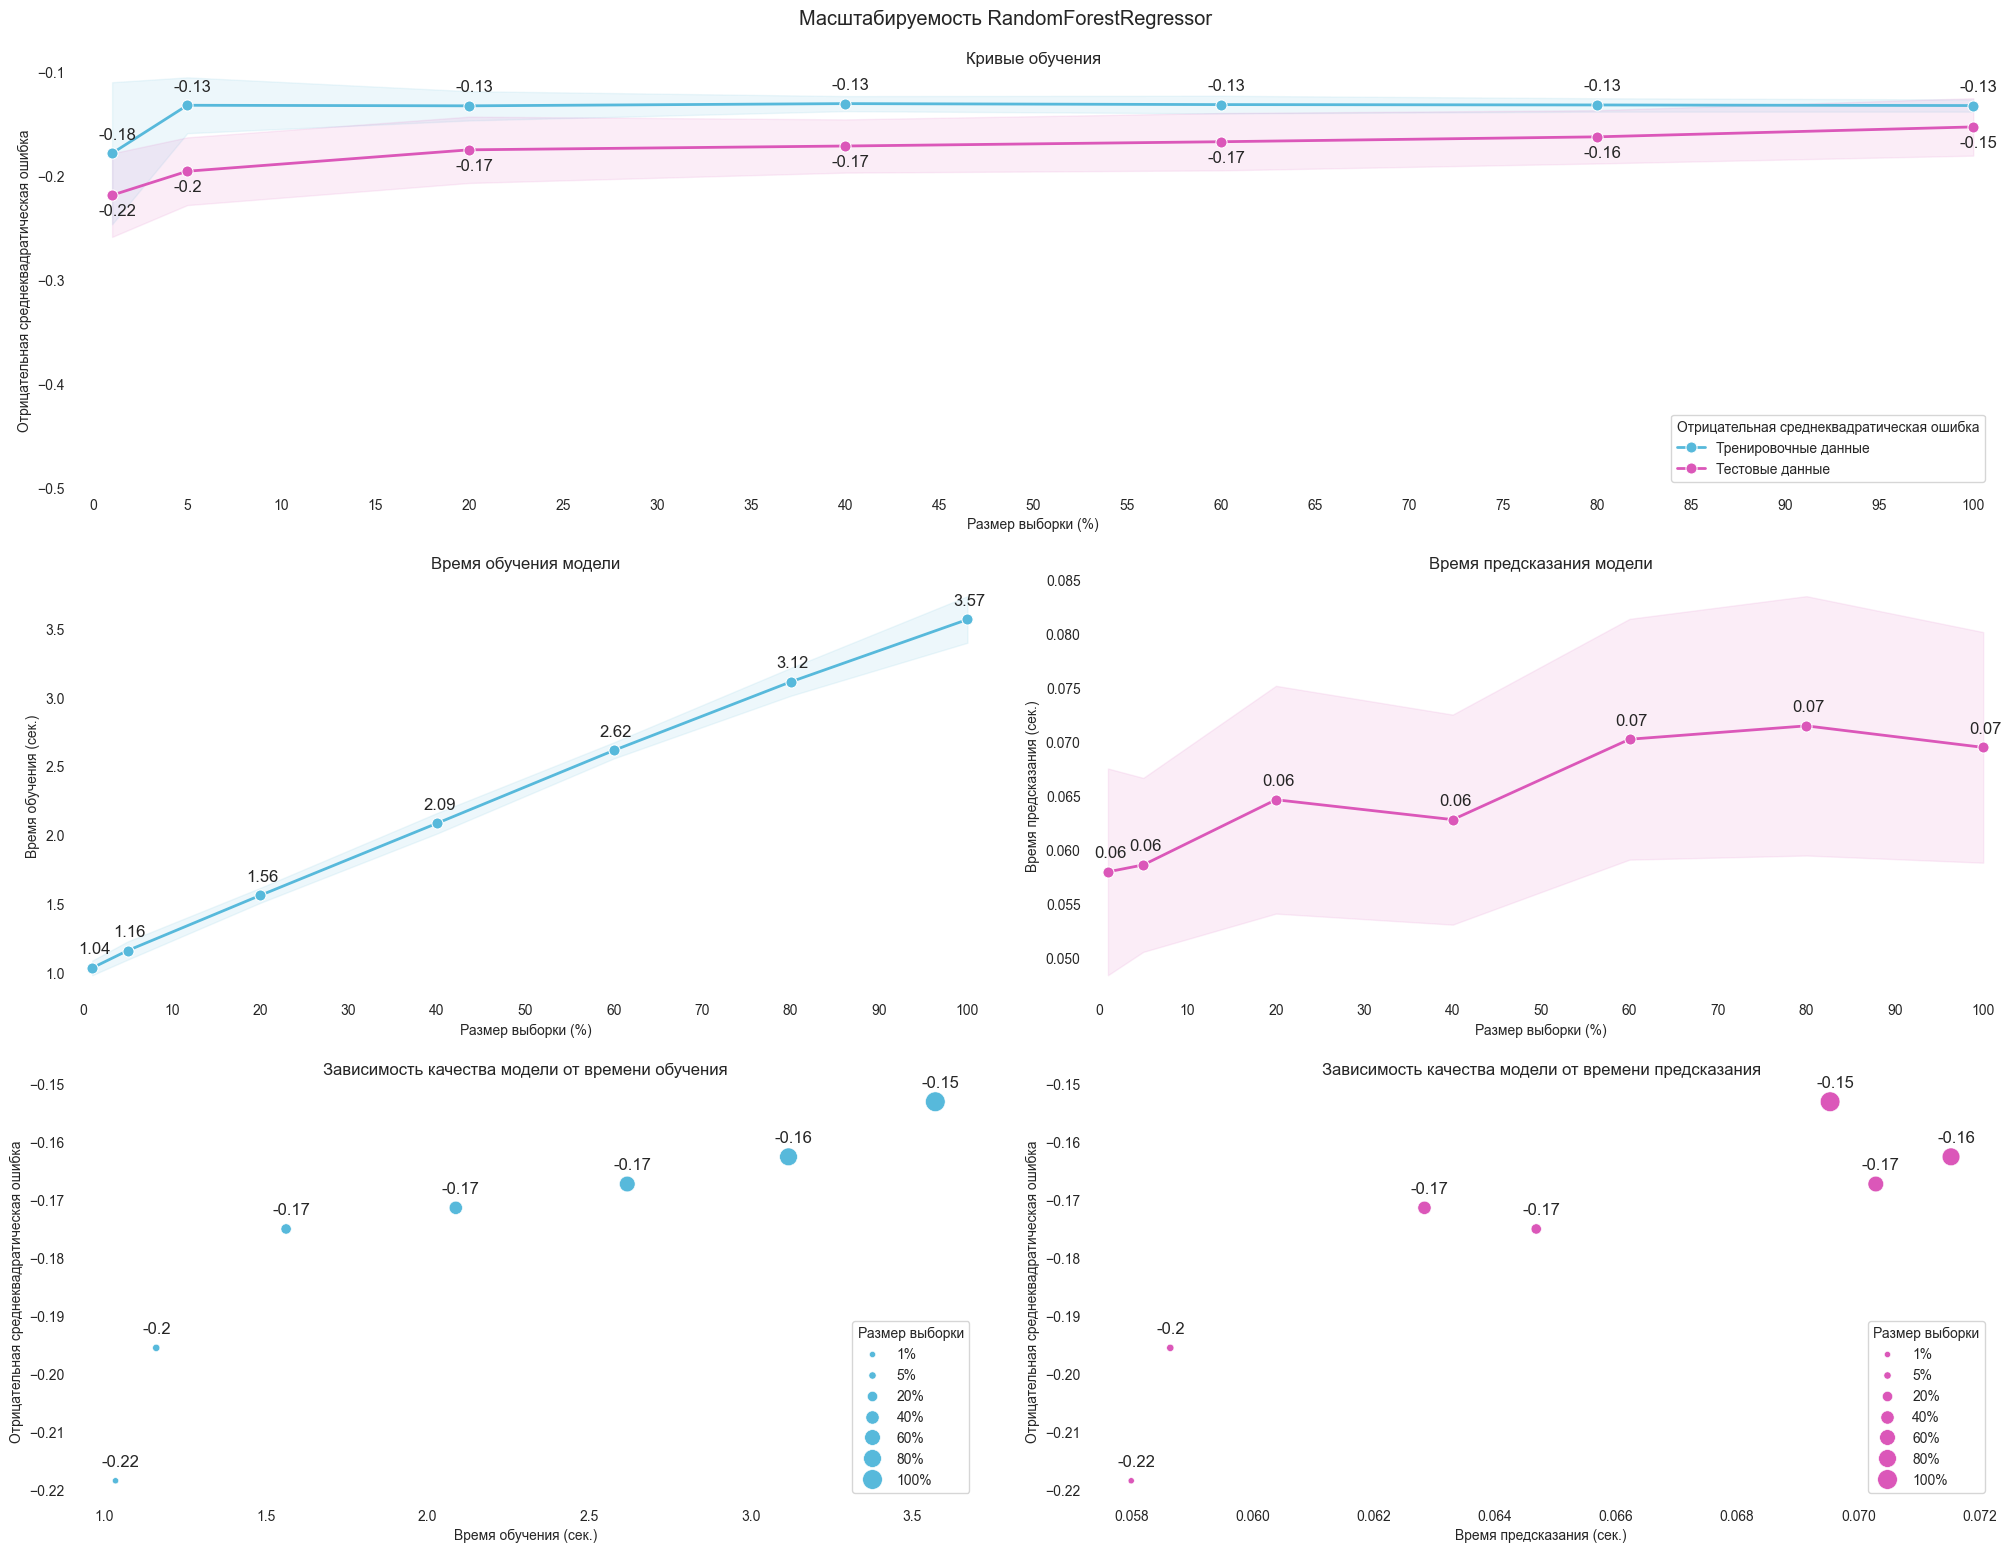

In [40]:
x_train_size = CV_TRAIN_SIZE
plot.scalability(
    train_sizes=pd.Series((train_sizes / x_train_size * 100).round(1)),
    train_scores=pd.DataFrame(train_scores),
    test_scores=pd.DataFrame(test_scores),
    fit_times=pd.DataFrame(fit_times),
    score_times=pd.DataFrame(score_times),
    title=f'Масштабируемость RandomForestRegressor'
)

In [41]:
predict = rf_rgs.predict(x_valid)

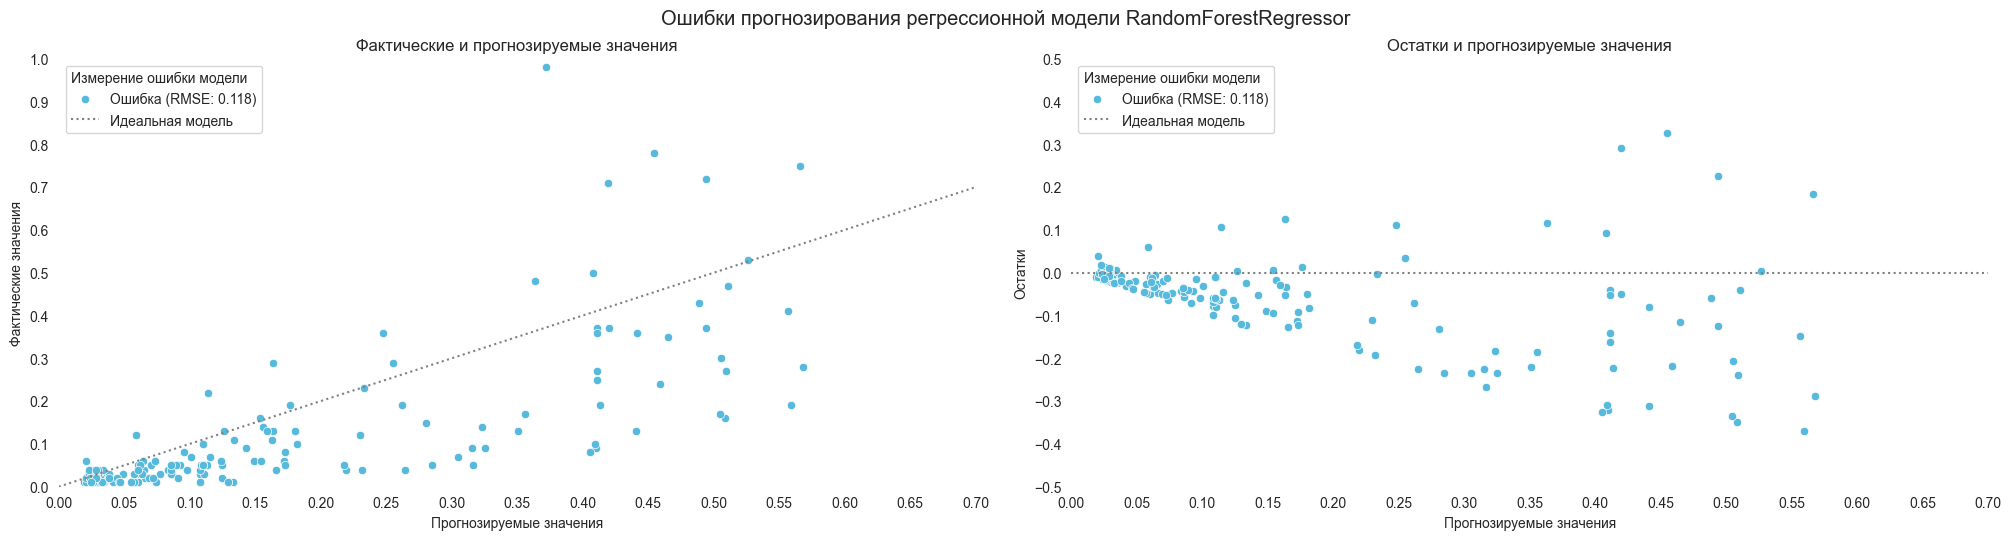

In [42]:
plot.error(
    y_true=pd.Series(y_valid), 
    y_predict=pd.Series(predict),
    title='Ошибки прогнозирования регрессионной модели RandomForestRegressor'
)

### Тестирование HistGradientBoostingRegressor

In [43]:
estimator = HistGradientBoostingRegressor(random_state=RANDOM_STATE)
model = Pipeline(
    steps=[
        ('standardizer', standardizer),
        ('estimator', estimator),
    ]
)
model

Pipeline(steps=[('standardizer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  TargetEncoder(random_state=42),
                                                  ['platform', 'publisher',
                                                   'developer', 'america',
                                                   'europe', 'japan',
                                                   'other'])])),
                ('estimator', HistGradientBoostingRegressor(random_state=42))])

In [44]:
param_grid = {
    'estimator__learning_rate': [0.1, 0.5, 1],
    'estimator__max_depth': np.arange(2, 9, 2),
    'estimator__max_iter': np.arange(250, 1001, 250),
    'estimator__max_leaf_nodes': np.arange(20, 41, 20),
    'estimator__min_samples_leaf': np.arange(20, 41, 20),
    'estimator__l2_regularization': np.linspace(0.0, 0.75, 4),
}

In [45]:
hgb_rgs = RandomizedSearchCV(
    estimator=model,
    n_iter=10,
    cv=cv,
    scoring=scoring,
    param_distributions=param_grid,
    verbose=CV_VERBOSE
)

hgb_rgs.fit(x_train, y_train);

Fitting 15 folds for each of 10 candidates, totalling 150 fits
[CV 1/15] END estimator__l2_regularization=0.75, estimator__learning_rate=1, estimator__max_depth=4, estimator__max_iter=500, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=40;, score=-0.241 total time=   1.6s
[CV 2/15] END estimator__l2_regularization=0.75, estimator__learning_rate=1, estimator__max_depth=4, estimator__max_iter=500, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=40;, score=-0.265 total time=   0.9s
[CV 3/15] END estimator__l2_regularization=0.75, estimator__learning_rate=1, estimator__max_depth=4, estimator__max_iter=500, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=40;, score=-0.207 total time=   1.0s
[CV 4/15] END estimator__l2_regularization=0.75, estimator__learning_rate=1, estimator__max_depth=4, estimator__max_iter=500, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=40;, score=-0.235 total time=   1.0s
[CV 5/15] END estimator__l2_regularization=0.75, esti

In [46]:
cv_results = pd.DataFrame(
    data=hgb_rgs.cv_results_, 
).sort_values('rank_test_score')
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__min_samples_leaf,param_estimator__max_leaf_nodes,param_estimator__max_iter,param_estimator__max_depth,param_estimator__learning_rate,param_estimator__l2_regularization,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
7,0.940650,0.056791,0.046739,0.007942,40,20,1000,2,0.1,0.75,...,-0.141233,-0.149140,-0.141953,-0.147198,-0.134097,-0.143648,-0.108574,-0.157305,0.025694,1
4,0.273136,0.044478,0.023565,0.008475,40,20,250,2,0.5,0.5,...,-0.141028,-0.152796,-0.144759,-0.151290,-0.135283,-0.147644,-0.111277,-0.159877,0.025928,2
6,0.993602,0.048000,0.049603,0.009307,20,40,1000,2,0.1,0.0,...,-0.138487,-0.151781,-0.153884,-0.152371,-0.132397,-0.144648,-0.113122,-0.159909,0.025319,3
8,0.562528,0.075299,0.034240,0.006697,20,40,500,2,0.5,0.0,...,-0.146529,-0.166597,-0.162135,-0.161156,-0.137604,-0.150323,-0.118613,-0.167527,0.024764,4
5,0.279344,0.031239,0.024474,0.006786,20,40,250,2,1,0.0,...,-0.152576,-0.191540,-0.170759,-0.170784,-0.141099,-0.160125,-0.115433,-0.172541,0.025481,5


In [47]:
results.loc['HistGradientBoostingRegressor', 'Время обучения'] = cv_results.iloc[0, 0]
results.loc['HistGradientBoostingRegressor', 'Время предсказания'] = cv_results.iloc[0, 2]
results.loc['HistGradientBoostingRegressor', 'RMSE'] = cv_results.iloc[0, -3]

In [48]:
(train_sizes,
 train_scores, test_scores,
 fit_times, score_times) = learning_curve(
    estimator=hgb_rgs.best_estimator_,
    X=x_train,
    y=y_train,
    train_sizes=LEARNING_CURVE_TRAIN_SIZES,
    cv=cv,
    n_jobs=N_JOBS,
    scoring='neg_root_mean_squared_error',
    return_times=True,
    verbose=CV_VERBOSE
)

[learning_curve] Training set sizes: [  20  100  400  800 1200 1600 2000]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  34 out of 105 | elapsed:   13.7s remaining:   28.6s
[Parallel(n_jobs=4)]: Done  70 out of 105 | elapsed:   28.0s remaining:   14.0s
[Parallel(n_jobs=4)]: Done 105 out of 105 | elapsed:   41.9s finished


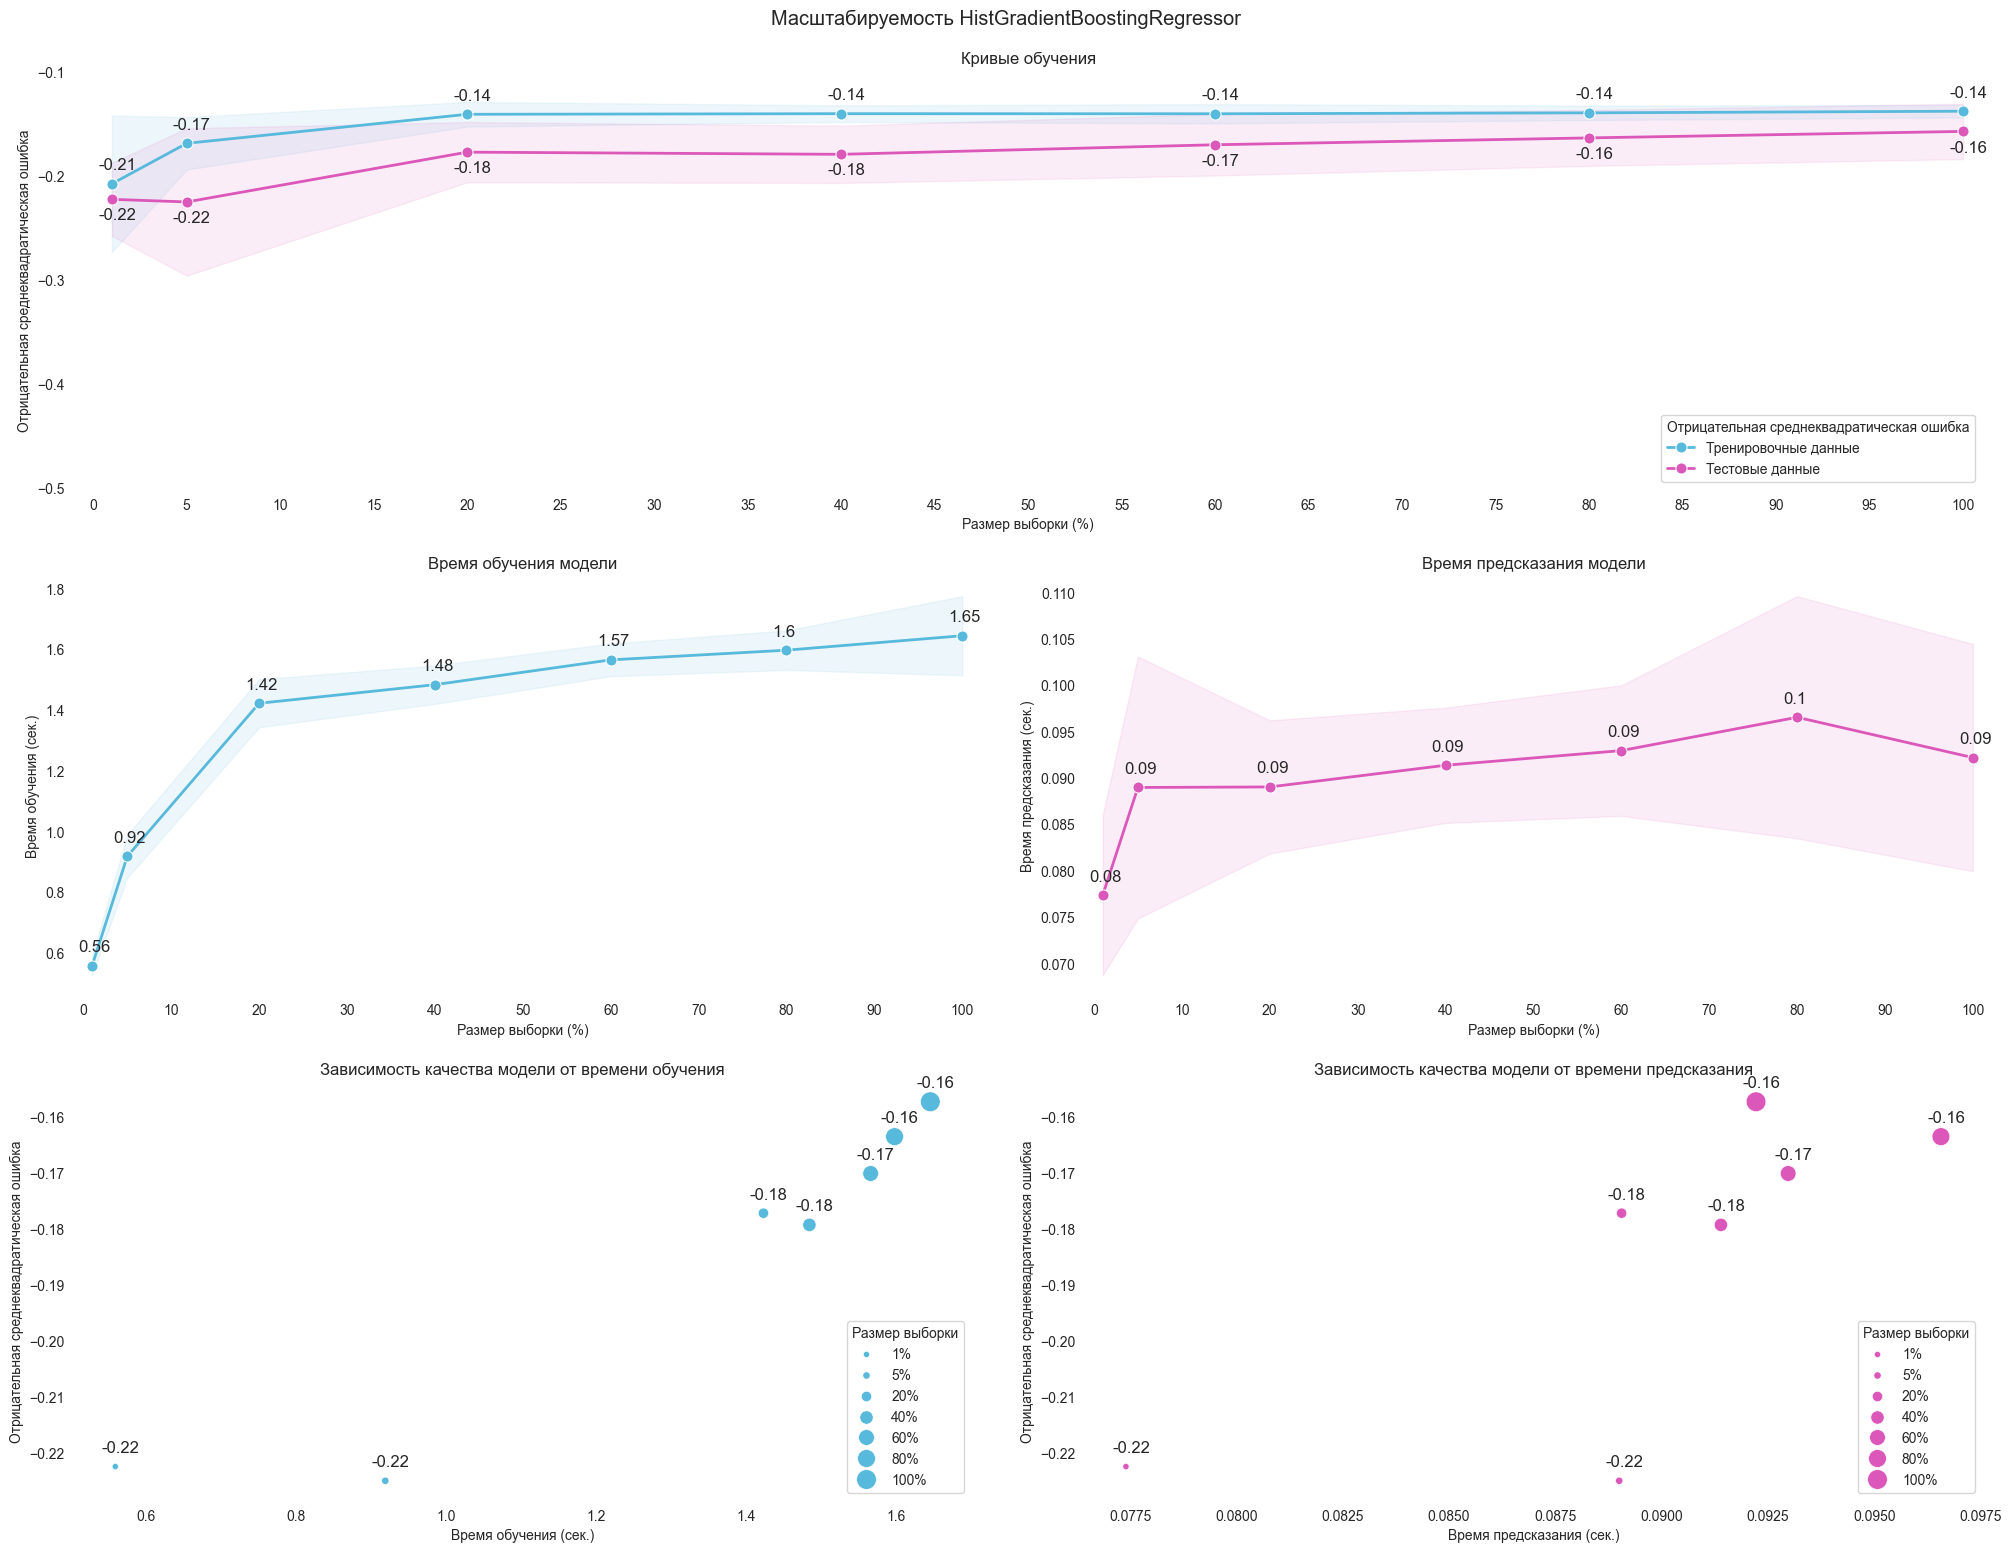

In [49]:
x_train_size = CV_TRAIN_SIZE
plot.scalability(
    train_sizes=pd.Series((train_sizes / x_train_size * 100).round(1)),
    train_scores=pd.DataFrame(train_scores),
    test_scores=pd.DataFrame(test_scores),
    fit_times=pd.DataFrame(fit_times),
    score_times=pd.DataFrame(score_times),
    title=f'Масштабируемость HistGradientBoostingRegressor'
)

In [50]:
predict = hgb_rgs.predict(x_valid)

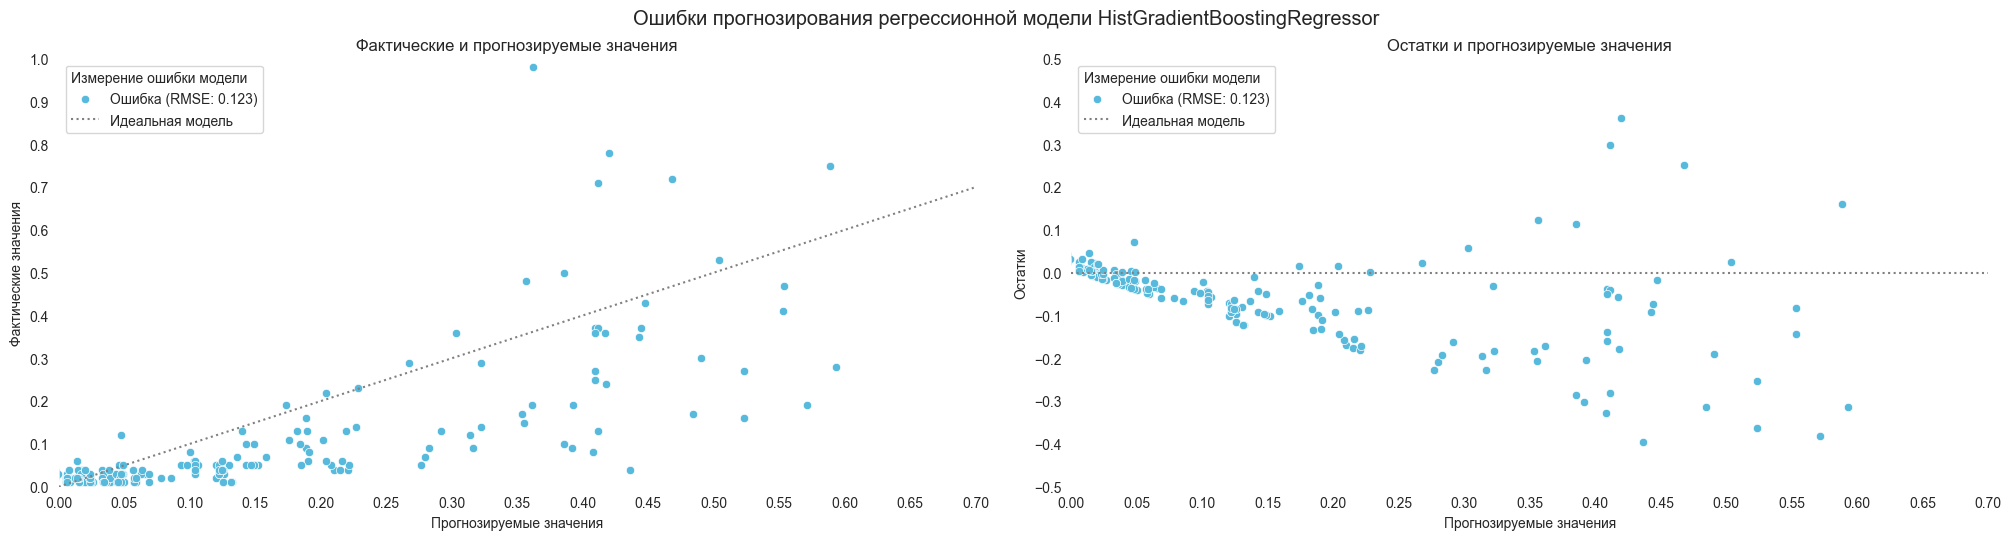

In [51]:
plot.error(
    y_true=pd.Series(y_valid), 
    y_predict=pd.Series(predict),
    title='Ошибки прогнозирования регрессионной модели HistGradientBoostingRegressor'
)

### Тестирование LGBMRegressor

In [52]:
estimator = LGBMRegressor(
    random_state=RANDOM_STATE,
    verbosity=-1
)
model = Pipeline(
    steps=[
        ('standardizer', standardizer),
        ('estimator', estimator),
    ]
)
model

Pipeline(steps=[('standardizer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  TargetEncoder(random_state=42),
                                                  ['platform', 'publisher',
                                                   'developer', 'america',
                                                   'europe', 'japan',
                                                   'other'])])),
                ('estimator', LGBMRegressor(random_state=42, verbosity=-1))])

In [53]:
param_grid = {
    'estimator__learning_rate': [0.1, 0.5, 1],
    'estimator__max_depth': np.arange(2, 9, 2),
    'estimator__n_estimators': np.arange(250, 1001, 250),
    'estimator__num_leaves': np.arange(20, 41, 20),
    'estimator__reg_alpha': np.linspace(0.0, 0.75, 4),
    'estimator__reg_lambda': np.linspace(0.0, 0.75, 4),
}

In [54]:
lgbm_rgs = RandomizedSearchCV(
    estimator=model,
    n_iter=10,
    cv=cv,
    scoring=scoring,
    param_distributions=param_grid,
    verbose=CV_VERBOSE
)

lgbm_rgs.fit(x_train, y_train);

Fitting 15 folds for each of 10 candidates, totalling 150 fits
[CV 1/15] END estimator__learning_rate=0.1, estimator__max_depth=8, estimator__n_estimators=500, estimator__num_leaves=40, estimator__reg_alpha=0.5, estimator__reg_lambda=0.5;, score=-0.212 total time=   0.3s
[CV 2/15] END estimator__learning_rate=0.1, estimator__max_depth=8, estimator__n_estimators=500, estimator__num_leaves=40, estimator__reg_alpha=0.5, estimator__reg_lambda=0.5;, score=-0.198 total time=   0.5s
[CV 3/15] END estimator__learning_rate=0.1, estimator__max_depth=8, estimator__n_estimators=500, estimator__num_leaves=40, estimator__reg_alpha=0.5, estimator__reg_lambda=0.5;, score=-0.153 total time=   0.3s
[CV 4/15] END estimator__learning_rate=0.1, estimator__max_depth=8, estimator__n_estimators=500, estimator__num_leaves=40, estimator__reg_alpha=0.5, estimator__reg_lambda=0.5;, score=-0.199 total time=   0.3s
[CV 5/15] END estimator__learning_rate=0.1, estimator__max_depth=8, estimator__n_estimators=500, esti

In [55]:
cv_results = pd.DataFrame(
    data=lgbm_rgs.cv_results_, 
).sort_values('rank_test_score')
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__reg_lambda,param_estimator__reg_alpha,param_estimator__num_leaves,param_estimator__n_estimators,param_estimator__max_depth,param_estimator__learning_rate,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
8,0.201590,0.023294,0.019542,0.005625,0.0,0.75,20,750,8,0.1,...,-0.138895,-0.154835,-0.143959,-0.140524,-0.131990,-0.137317,-0.104552,-0.156100,0.028217,1
4,0.254599,0.042707,0.021535,0.005803,0.5,0.5,20,500,6,0.1,...,-0.138935,-0.163581,-0.148543,-0.144021,-0.131527,-0.139682,-0.110274,-0.159655,0.028857,2
0,0.329095,0.095115,0.022139,0.005392,0.5,0.5,40,500,8,0.1,...,-0.143239,-0.164817,-0.150303,-0.145376,-0.135649,-0.138234,-0.108781,-0.160630,0.028427,3
5,0.227578,0.022490,0.023634,0.004685,0.5,0.0,20,1000,2,0.1,...,-0.137164,-0.160252,-0.155387,-0.151613,-0.135167,-0.144907,-0.113183,-0.161524,0.025903,4
7,0.163105,0.039609,0.015865,0.007034,0.75,0.75,20,1000,4,1,...,-0.145986,-0.169124,-0.153233,-0.151715,-0.138171,-0.150150,-0.113390,-0.166290,0.027930,5


In [56]:
results.loc['LGBMRegressor', 'Время обучения'] = cv_results.iloc[0, 0]
results.loc['LGBMRegressor', 'Время предсказания'] = cv_results.iloc[0, 2]
results.loc['LGBMRegressor', 'RMSE'] = cv_results.iloc[0, -3]

In [57]:
(train_sizes,
 train_scores, test_scores,
 fit_times, score_times) = learning_curve(
    estimator=lgbm_rgs.best_estimator_,
    X=x_train,
    y=y_train,
    train_sizes=LEARNING_CURVE_TRAIN_SIZES,
    cv=cv,
    n_jobs=N_JOBS,
    scoring='neg_root_mean_squared_error',
    return_times=True,
    verbose=CV_VERBOSE
)

[learning_curve] Training set sizes: [  20  100  400  800 1200 1600 2000]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  34 out of 105 | elapsed:    5.6s remaining:   11.9s
[Parallel(n_jobs=4)]: Done  70 out of 105 | elapsed:   10.2s remaining:    5.0s
[Parallel(n_jobs=4)]: Done 105 out of 105 | elapsed:   14.7s finished


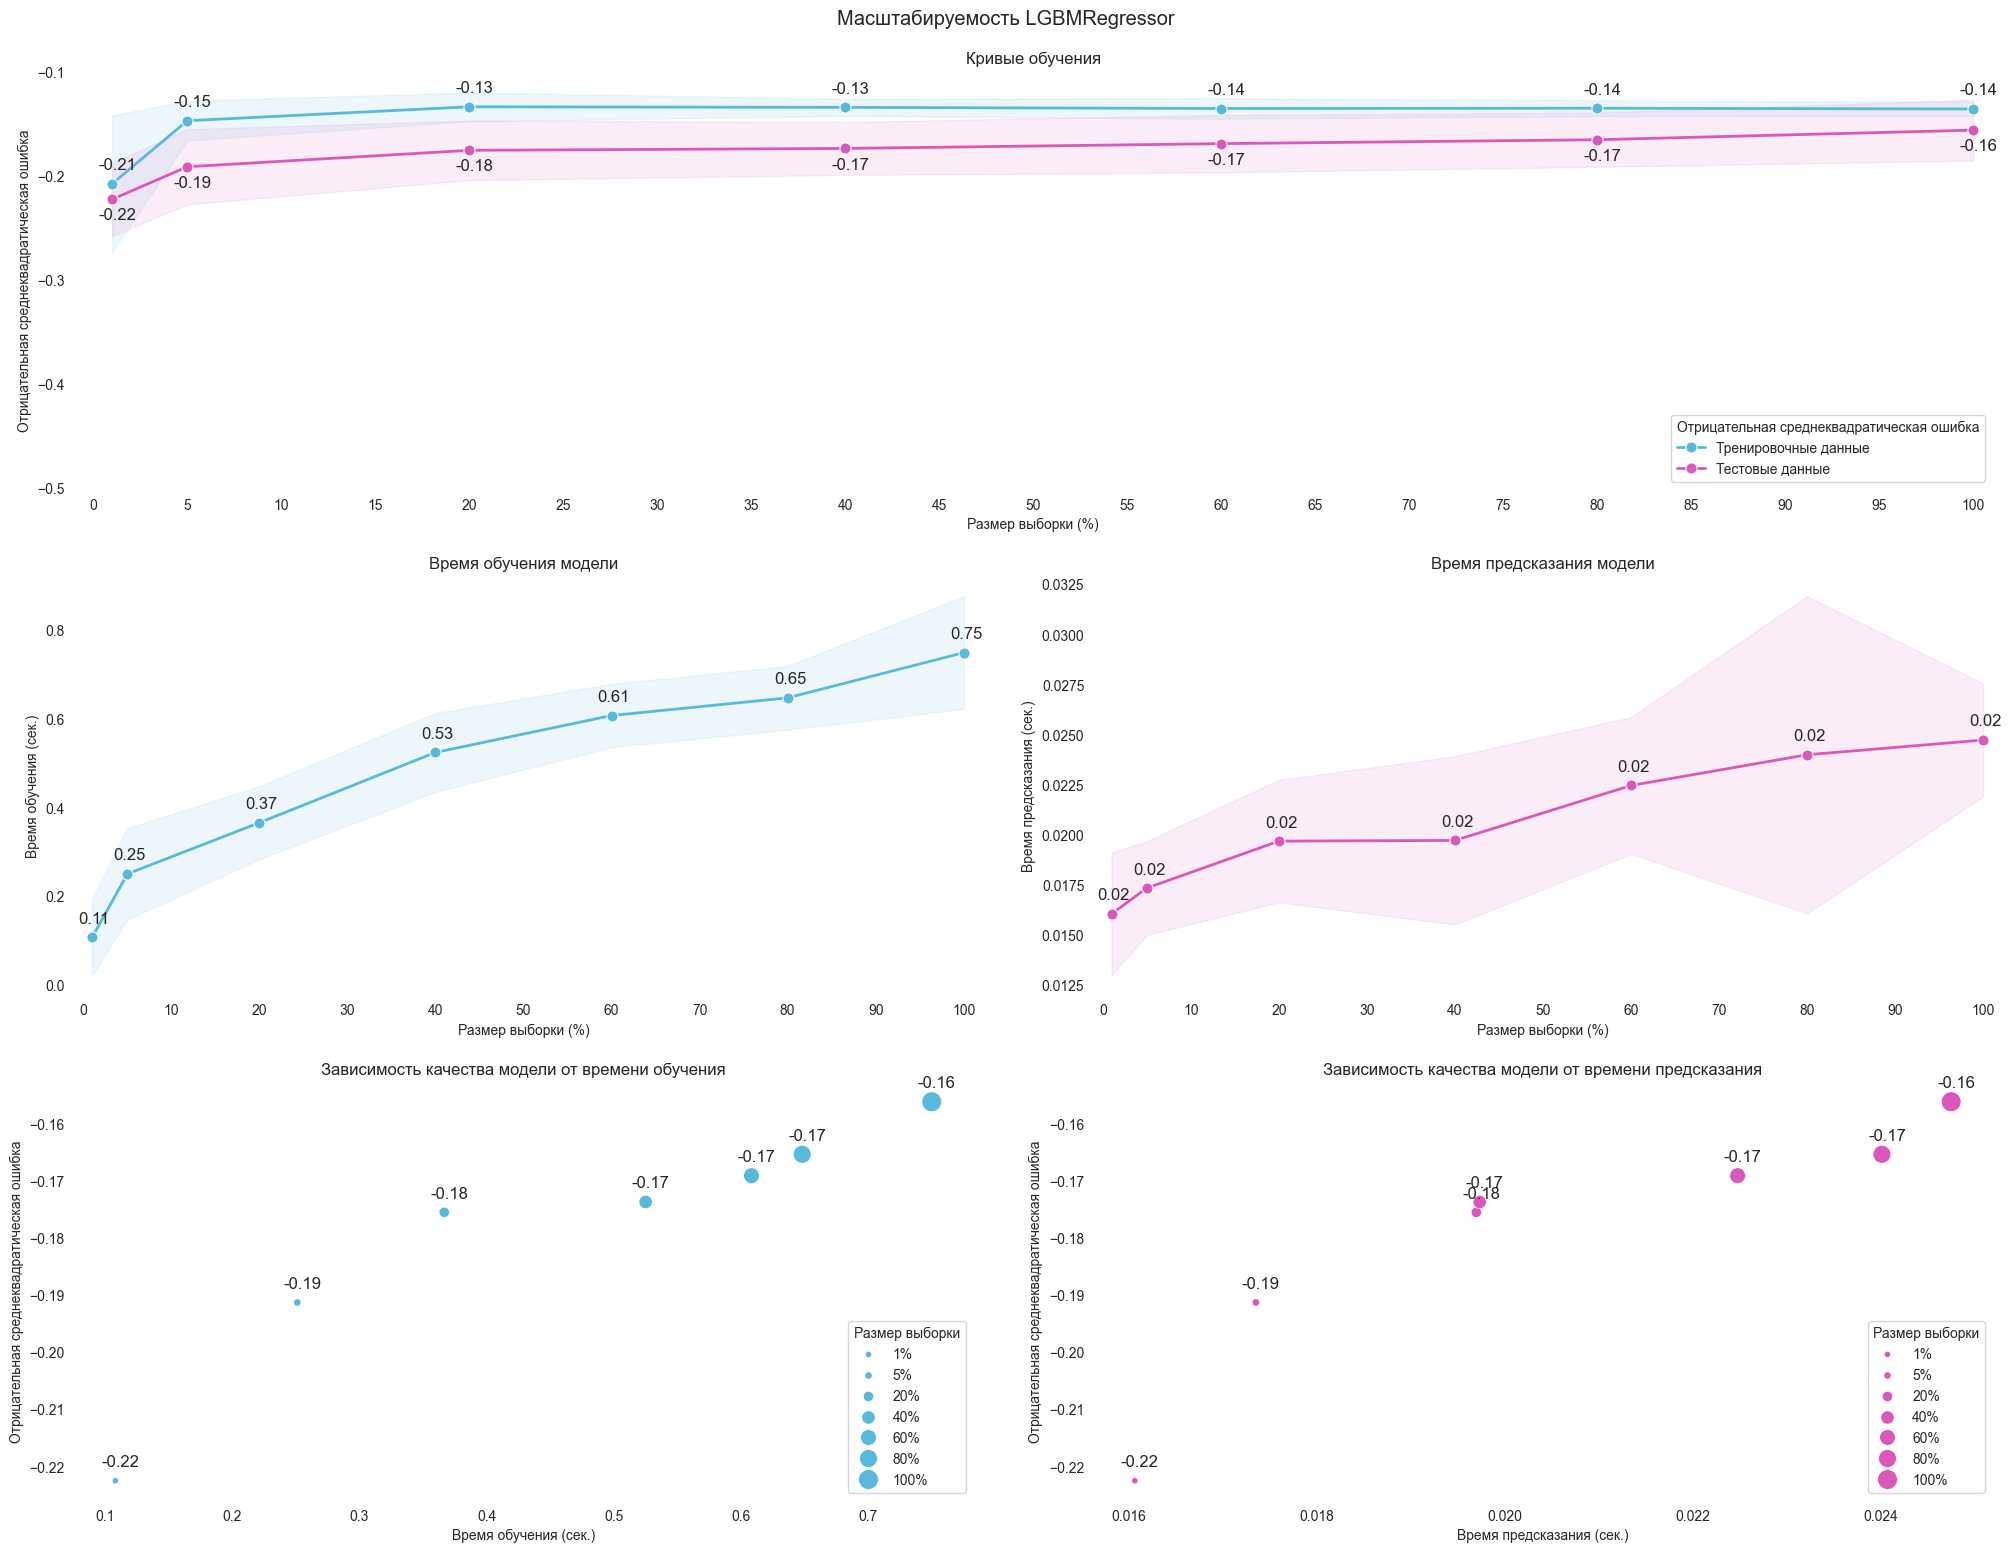

In [58]:
x_train_size = CV_TRAIN_SIZE
plot.scalability(
    train_sizes=pd.Series((train_sizes / x_train_size * 100).round(1)),
    train_scores=pd.DataFrame(train_scores),
    test_scores=pd.DataFrame(test_scores),
    fit_times=pd.DataFrame(fit_times),
    score_times=pd.DataFrame(score_times),
    title=f'Масштабируемость LGBMRegressor'
)

In [59]:
predict = lgbm_rgs.predict(x_valid)

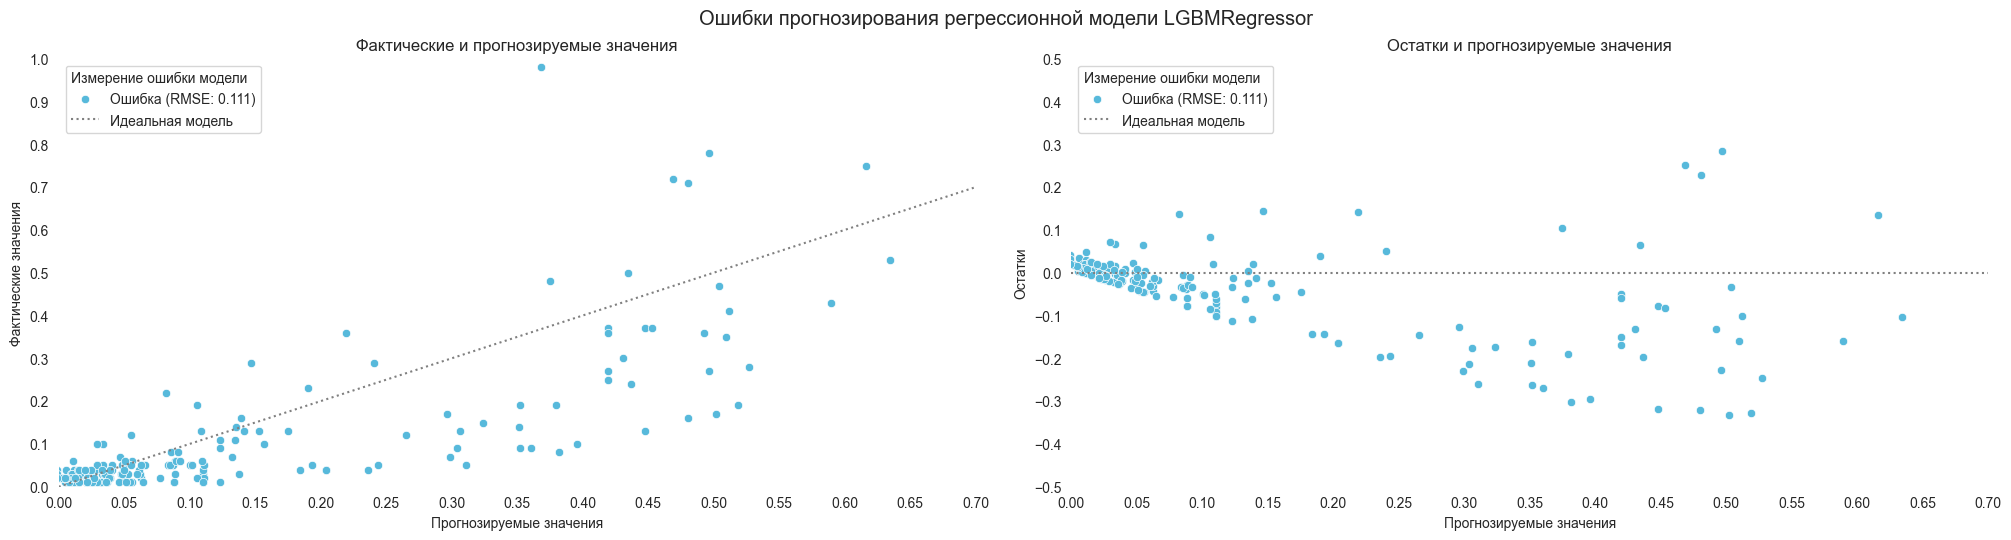

In [60]:
plot.error(
    y_true=pd.Series(y_valid), 
    y_predict=pd.Series(predict),
    title='Ошибки прогнозирования регрессионной модели LGBMRegressor'
)

### Тестирование XGBRegressor

In [61]:
estimator = XGBRegressor(
    random_state=RANDOM_STATE,
    verbosity=0
)
model = Pipeline(
    steps=[
        ('standardizer', standardizer),
        ('estimator', estimator),
    ]
)
model

Pipeline(steps=[('standardizer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  TargetEncoder(random_state=42),
                                                  ['platform', 'publisher',
                                                   'developer', 'america',
                                                   'europe', 'japan',
                                                   'other'])])),
                ('estimator',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [62]:
param_grid = {
    'estimator__learning_rate': [0.1, 0.5, 1],
    'estimator__max_depth': np.arange(2, 9, 2),
    'estimator__n_estimators': np.arange(250, 1001, 250),
    'estimator__max_leaves': np.arange(20, 41, 20),
    'estimator__reg_alpha': np.linspace(0.0, 0.75, 4),
    'estimator__reg_lambda': np.linspace(0.0, 0.75, 4),
}

In [63]:
xgb_rgs = RandomizedSearchCV(
    estimator=model,
    n_iter=10,
    cv=cv,
    scoring=scoring,
    param_distributions=param_grid,
    verbose=CV_VERBOSE
)

xgb_rgs.fit(x_train, y_train);

Fitting 15 folds for each of 10 candidates, totalling 150 fits
[CV 1/15] END estimator__learning_rate=0.1, estimator__max_depth=2, estimator__max_leaves=40, estimator__n_estimators=250, estimator__reg_alpha=0.75, estimator__reg_lambda=0.5;, score=-0.194 total time=   0.6s
[CV 2/15] END estimator__learning_rate=0.1, estimator__max_depth=2, estimator__max_leaves=40, estimator__n_estimators=250, estimator__reg_alpha=0.75, estimator__reg_lambda=0.5;, score=-0.184 total time=   0.1s
[CV 3/15] END estimator__learning_rate=0.1, estimator__max_depth=2, estimator__max_leaves=40, estimator__n_estimators=250, estimator__reg_alpha=0.75, estimator__reg_lambda=0.5;, score=-0.149 total time=   0.2s
[CV 4/15] END estimator__learning_rate=0.1, estimator__max_depth=2, estimator__max_leaves=40, estimator__n_estimators=250, estimator__reg_alpha=0.75, estimator__reg_lambda=0.5;, score=-0.191 total time=   0.1s
[CV 5/15] END estimator__learning_rate=0.1, estimator__max_depth=2, estimator__max_leaves=40, est

In [64]:
cv_results = pd.DataFrame(
    data=xgb_rgs.cv_results_, 
).sort_values('rank_test_score')
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__reg_lambda,param_estimator__reg_alpha,param_estimator__n_estimators,param_estimator__max_leaves,param_estimator__max_depth,param_estimator__learning_rate,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
0,0.256023,0.116284,0.023805,0.004104,0.5,0.75,250,40,2,0.1,...,-0.131453,-0.145437,-0.144838,-0.136221,-0.133825,-0.138604,-0.109103,-0.153403,0.024627,1
5,0.658851,0.549934,0.020286,0.004409,0.25,0.75,750,20,6,0.1,...,-0.136189,-0.153852,-0.147267,-0.143948,-0.134006,-0.142041,-0.113286,-0.156525,0.025258,2
4,0.314997,0.054069,0.017942,0.002522,0.75,0.75,500,20,2,0.5,...,-0.132194,-0.150087,-0.145434,-0.145683,-0.134860,-0.145037,-0.110608,-0.157176,0.025800,3
1,0.330402,0.023863,0.025730,0.002405,0.75,0.5,250,20,4,0.1,...,-0.138384,-0.157186,-0.149855,-0.149883,-0.135566,-0.145468,-0.111191,-0.158441,0.025749,4
8,0.446188,0.025978,0.019135,0.002393,0.0,0.25,750,40,2,0.1,...,-0.133264,-0.150236,-0.153369,-0.149959,-0.134439,-0.144853,-0.117228,-0.158927,0.024082,5


In [65]:
results.loc['XGBRegressor', 'Время обучения'] = cv_results.iloc[0, 0]
results.loc['XGBRegressor', 'Время предсказания'] = cv_results.iloc[0, 2]
results.loc['XGBRegressor', 'RMSE'] = cv_results.iloc[0, -3]

In [66]:
(train_sizes,
 train_scores, test_scores,
 fit_times, score_times) = learning_curve(
    estimator=xgb_rgs.best_estimator_,
    X=x_train,
    y=y_train,
    train_sizes=LEARNING_CURVE_TRAIN_SIZES,
    cv=cv,
    n_jobs=N_JOBS,
    scoring='neg_root_mean_squared_error',
    return_times=True,
    verbose=CV_VERBOSE
)

[learning_curve] Training set sizes: [  20  100  400  800 1200 1600 2000]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  34 out of 105 | elapsed:    2.2s remaining:    4.7s
[Parallel(n_jobs=4)]: Done  70 out of 105 | elapsed:    4.4s remaining:    2.1s
[Parallel(n_jobs=4)]: Done 105 out of 105 | elapsed:    6.4s finished


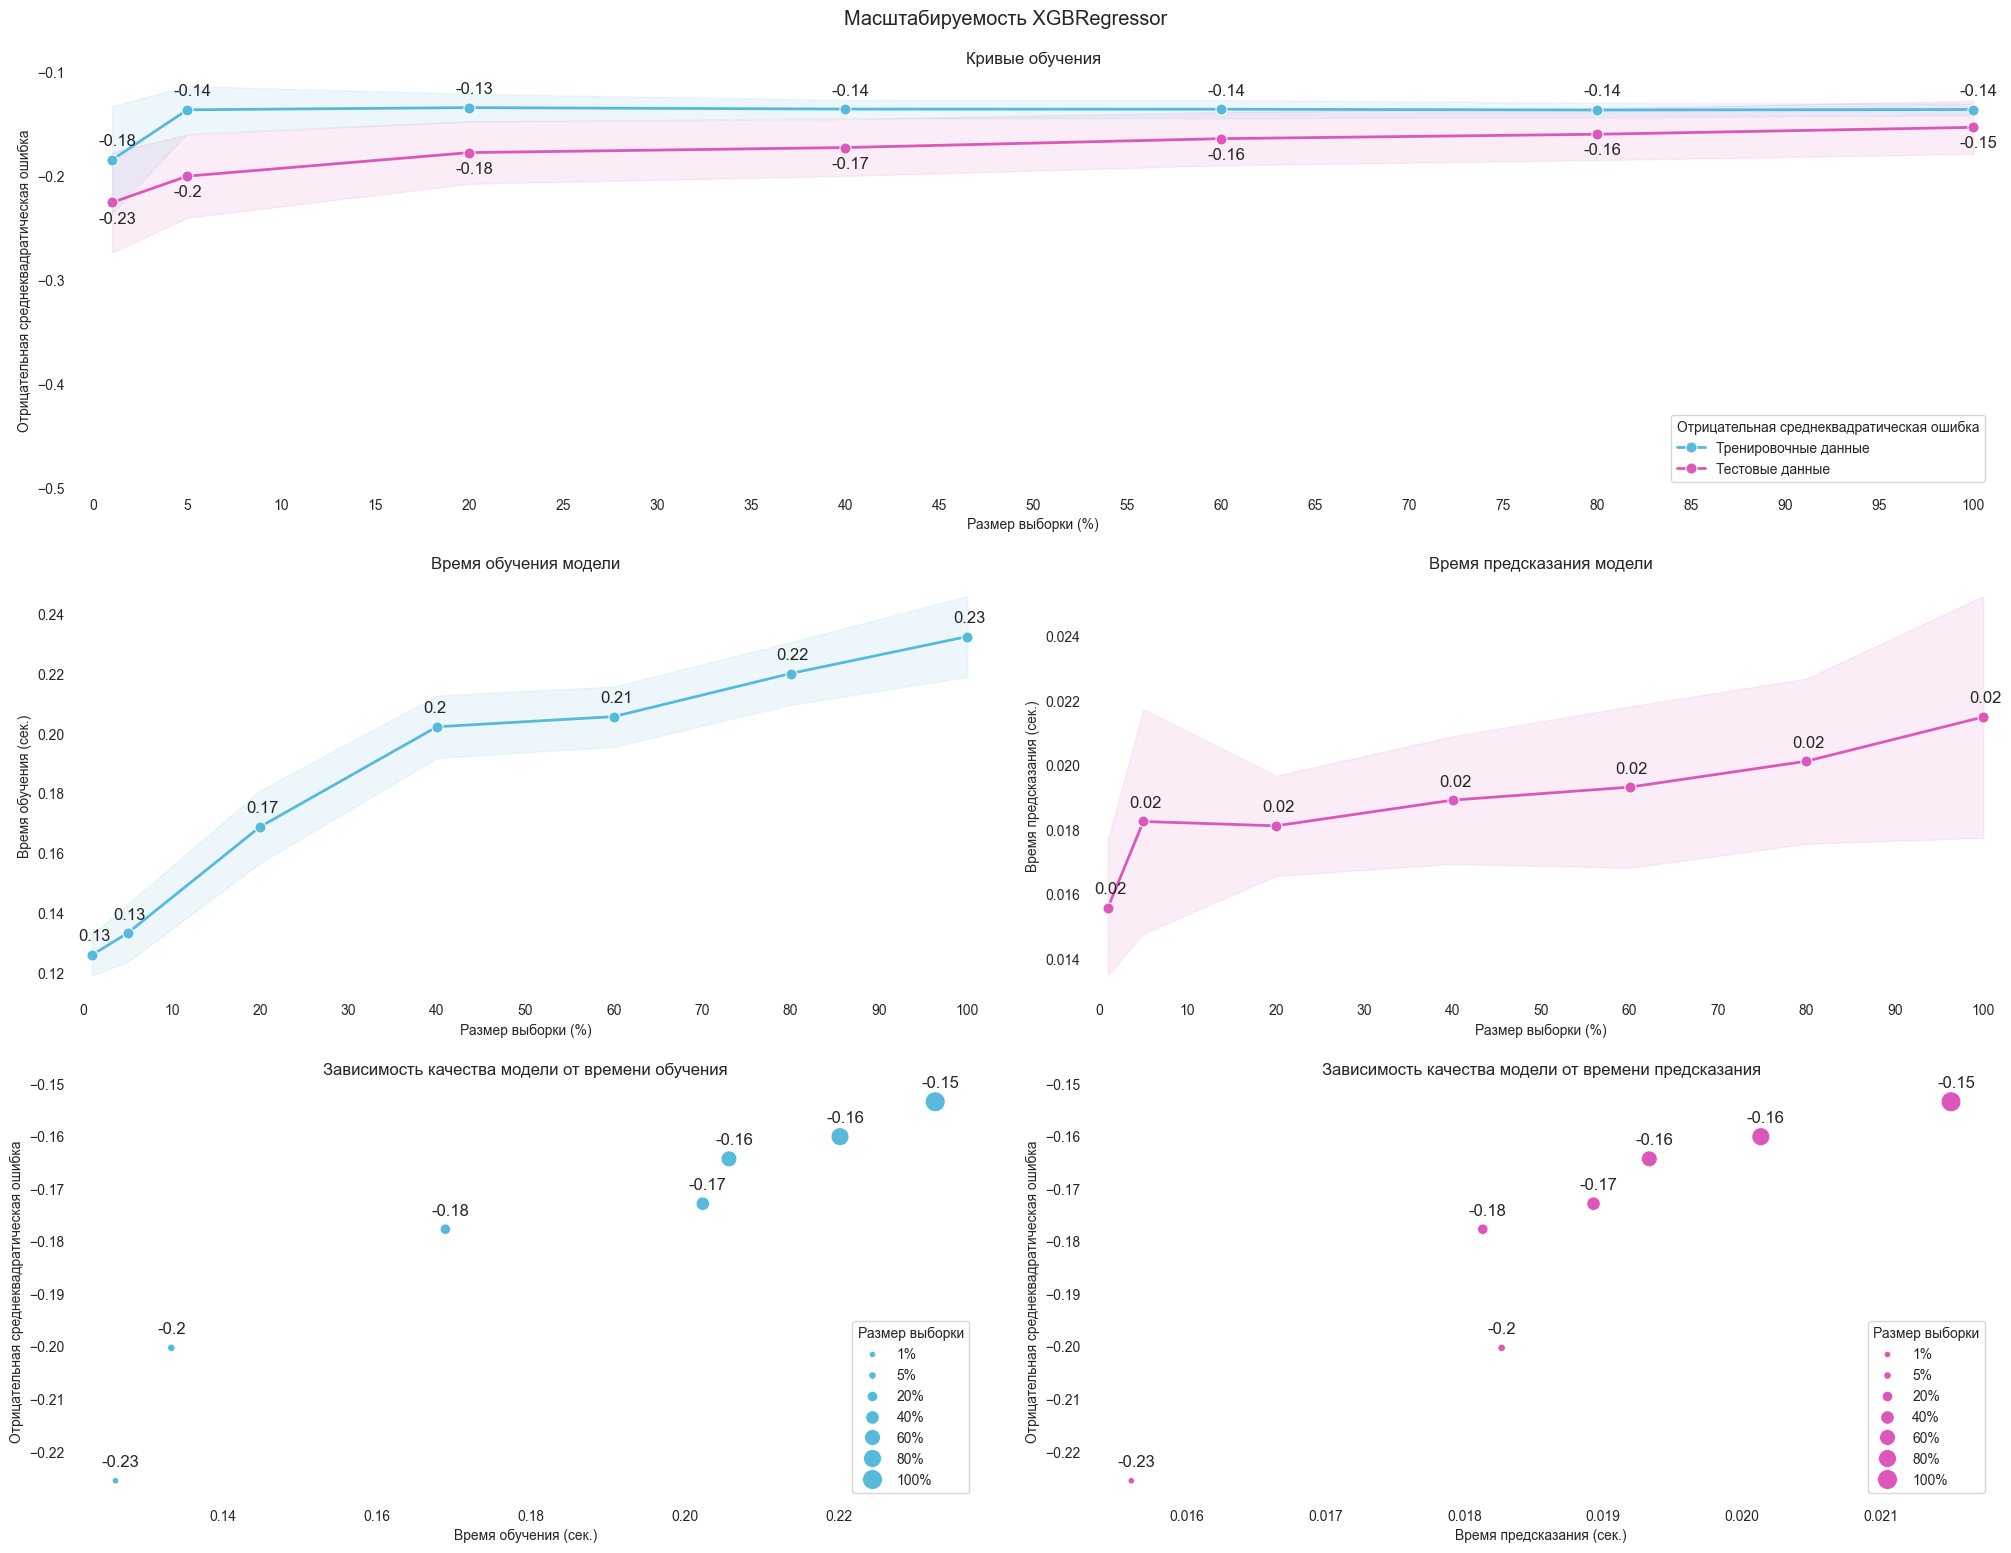

In [67]:
x_train_size = CV_TRAIN_SIZE
plot.scalability(
    train_sizes=pd.Series((train_sizes / x_train_size * 100).round(1)),
    train_scores=pd.DataFrame(train_scores),
    test_scores=pd.DataFrame(test_scores),
    fit_times=pd.DataFrame(fit_times),
    score_times=pd.DataFrame(score_times),
    title=f'Масштабируемость XGBRegressor'
)

In [68]:
predict = xgb_rgs.predict(x_valid)

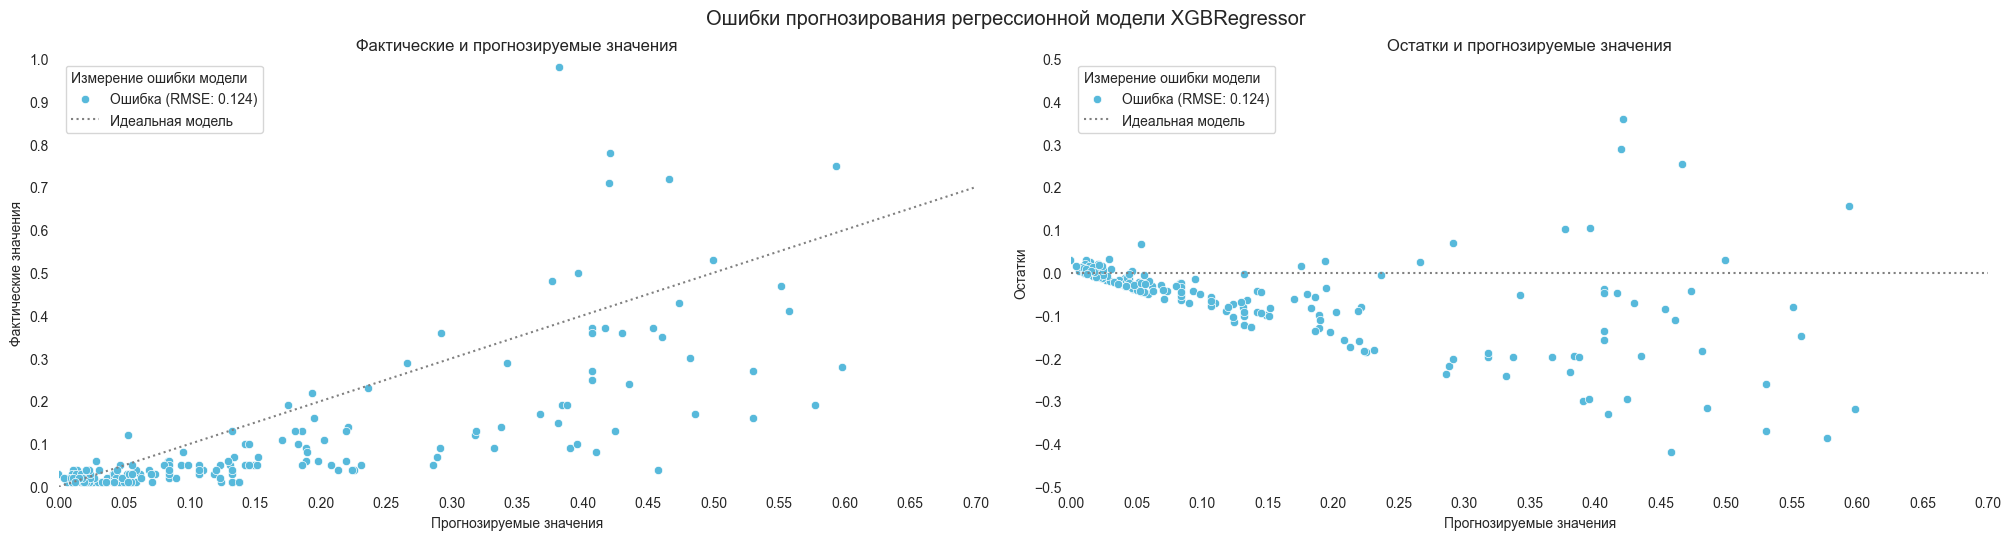

In [69]:
plot.error(
    y_true=pd.Series(y_valid), 
    y_predict=pd.Series(predict),
    title='Ошибки прогнозирования регрессионной модели XGBRegressor'
)

### Выводы по тестированию моделей
***

In [70]:
results.style.format(na_rep='-')

,Время обучения,Время предсказания,RMSE
DecisionTreeRegressor,0.025083,0.008662,-0.160952
RandomForestRegressor,2.761753,0.057065,-0.153003
HistGradientBoostingRegressor,0.940650,0.046739,-0.157305
LGBMRegressor,0.201590,0.019542,-0.156100
XGBRegressor,0.256023,0.023805,-0.153403


1. Для кодирования признаков использован **TargetEncoder**.
2. Дляля оценки эффективности **предсказательной способности** модели использована метрика **RMSE**.
3. Для **оценки эффективности** были выбраны следующие показатели:
    - время обучения;
    - время предсказания;
    - RMSE.
4. DecisionTreeRegressor:
    - результаты кросс-валидации:
        - среднее время обучения: до **0.02** сек.;
        - среднее время предсказания: до **0.01** сек.;
        - среднее значение RMSE: **0.160**.
    - оценка масштабируемости:
        - кривые обучения показывают, что признак переобучения модели **отсутствует**;
        - **добавление новых данных** вероятнее всего **не улучшит** предсказательную способность модели;
        - при добавении новых данных **время обучения** и **время предсказания** возрастают **линейно**.
    - оценка ошибки прогнозирования на валидационной выборке:
        - значение RMSE - **0.124**;
        - **присутствует гетероскедастичность** остатков.
5. RandomForestRegressor:
    - результаты кросс-валидации:
        - среднее время обучения: до **0.85** сек.;
        - среднее время предсказания: до **0.025** сек.;
        - среднее значение RMSE: **0.152**.
    - оценка масштабируемости:
        - кривые обучения показывают, что признак переобучения модели **отсутствует**;
        - **добавление новых данных** вероятнее всего **не улучшит** предсказательную способность модели;
        - при добавении новых данных **время обучения** и **время предсказания** возрастают **линейно**.
    - оценка ошибки прогнозирования на валидационной выборке:
        - значение RMSE - **0.118**;
        - **присутствует гетероскедастичность** остатков.
6. HistGradientBoostingRegressor:
    - результаты кросс-валидации:
        - среднее время обучения: до **0.25** сек.;
        - среднее время предсказания: до **0.02** сек.;
        - среднее значение RMSE: **0.153**.
    - оценка масштабируемости:
        - кривые обучения показывают, что признак переобучения модели **отсутствует**;
        - **добавление новых данных** вероятнее всего **не улучшит** предсказательную способность модели;
        - при добавении новых данных **время обучения** и **время предсказания** возрастают **линейно**.
    - оценка ошибки прогнозирования на валидационной выборке:
        - значение RMSE - **0.122**;
        - **присутствует гетероскедастичность** остатков.
6. LGBMRegressor:
    - результаты кросс-валидации:
        - среднее время обучения: до **0.1** сек.;
        - среднее время предсказания: до **0.02** сек.;
        - среднее значение RMSE: **0.154**.
    - оценка масштабируемости:
        - кривые обучения показывают, что признак переобучения модели **отсутствует**;
        - **добавление новых данных** вероятнее всего **не улучшит** предсказательную способность модели;
        - при добавении новых данных **время обучения** и **время предсказания** возрастают **линейно**.
    - оценка ошибки прогнозирования на валидационной выборке:
        - значение RMSE - **0.122**;
        - **присутствует гетероскедастичность** остатков.
7. XGBRegressor:
    - результаты кросс-валидации:
        - среднее время обучения: до **0.2** сек.;
        - среднее время предсказания: до **0.02** сек.;
        - среднее значение RMSE: **0.153**.
    - оценка масштабируемости:
        - кривые обучения показывают, что признак переобучения модели **отсутствует**;
        - **добавление новых данных** вероятнее всего **не улучшит** предсказательную способность модели;
        - при добавении новых данных **время обучения** и **время предсказания** возрастают **линейно**.
    - оценка ошибки прогнозирования на валидационной выборке:
        - значение RMSE - **0.125**;
        - **присутствует гетероскедастичность** остатков.

## Проверка модели на тестовой выборке

In [71]:
predict = rf_rgs.predict(x_test)

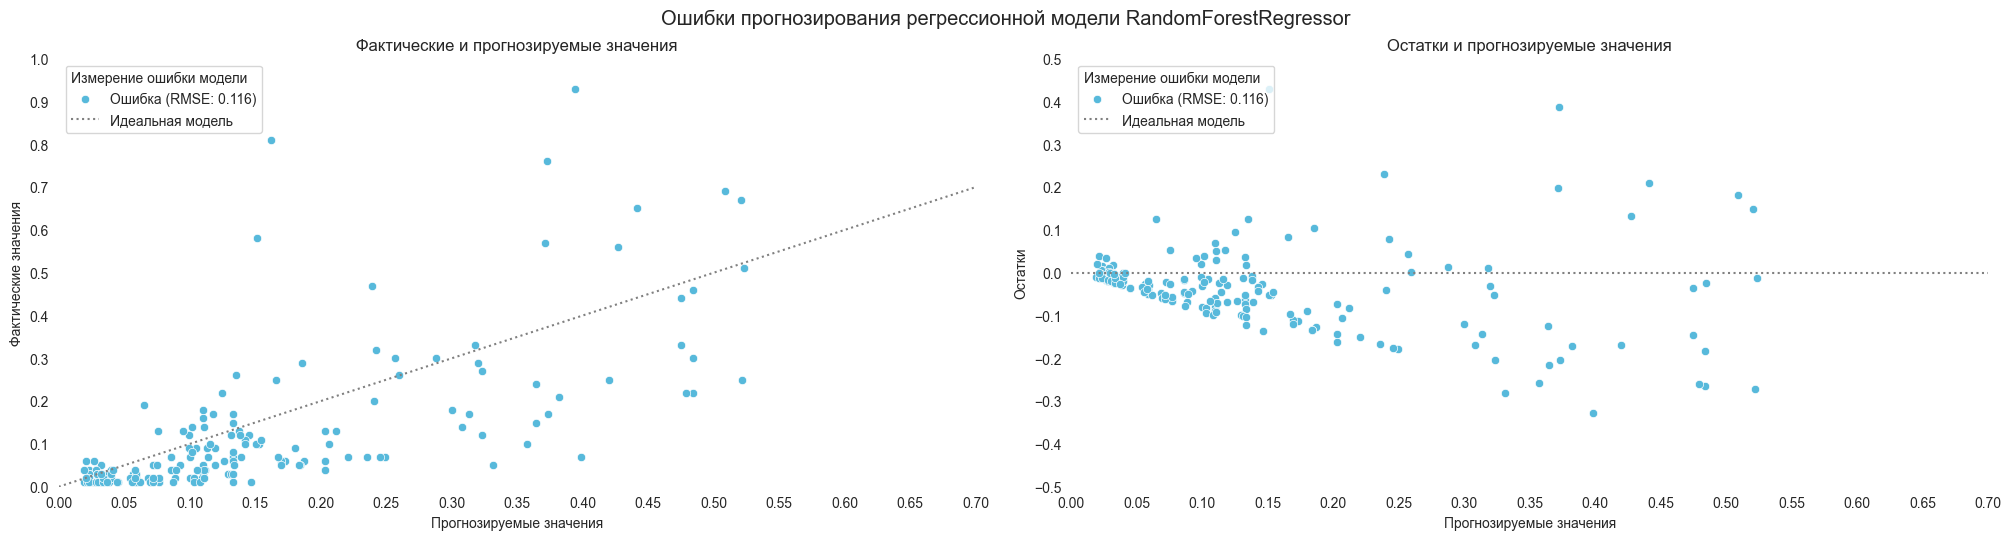

In [72]:
plot.error(
    y_true=pd.Series(y_test), 
    y_predict=pd.Series(predict),
    title='Ошибки прогнозирования регрессионной модели RandomForestRegressor'
)

## Сравнение с фиктивным регрессором

In [73]:
dummy_rgs = DummyRegressor(strategy="mean")
dummy_rgs

DummyRegressor()

In [74]:
dummy_rgs.fit(x_train[-1000:], y_train[-1000:])

DummyRegressor()

In [75]:
predict = dummy_rgs.predict(x_test)

In [76]:
root_mean_squared_error(y_test, predict)

0.1631689308661425

# Выводы

1. Отбор данных:
    - в качестве целевого признака был выбран признак **total**.
    - в качестве независимых признаков были выбраны:
        - date;
        - platform;
        - publisher;
        - developer;
        - america;
        - europe;
        - japan;
        - other.
    - были выбраны записи, в которых в поле **total** значения **не превышали 1.0**.
2. Преобразование данных:
    - для поля **date** был оставлен только год выпуска видеоигры;
    - для полей **america**, **europe**, **japan**, **other** значение было заменено на **True** и **False**, чтобы предотвратить **утечки целевого признака**.
3. Данные были разделены на **тренировочную**, **валидационную** и **тестовую** выборки в отношении **0.5:0.5:9**.
4. Тестирование моделей:
    - Для кодирования признаков использован **TargetEncoder**.
    - Дляля оценки эффективности **предсказательной способности** модели использована метрика **RMSE**.
    - Для **оценки эффективности** были выбраны следующие показатели:
        - время обучения;
        - время предсказания;
        - RMSE.
    1. DecisionTreeRegressor:
        - результаты кросс-валидации:
            - среднее время обучения: до **0.02** сек.;
            - среднее время предсказания: до **0.01** сек.;
            - среднее значение RMSE: **0.160**.
        - оценка масштабируемости:
            - кривые обучения показывают, что признак переобучения модели **отсутствует**;
            - **добавление новых данных** вероятнее всего **не улучшит** предсказательную способность модели;
            - при добавении новых данных **время обучения** и **время предсказания** возрастают **линейно**.
        - оценка ошибки прогнозирования на валидационной выборке:
            - значение RMSE - **0.124**;
            - **присутствует гетероскедастичность** остатков.
    2. RandomForestRegressor:
        - результаты кросс-валидации:
            - среднее время обучения: до **0.85** сек.;
            - среднее время предсказания: до **0.025** сек.;
            - среднее значение RMSE: **0.152**.
        - оценка масштабируемости:
            - кривые обучения показывают, что признак переобучения модели **отсутствует**;
            - **добавление новых данных** вероятнее всего **не улучшит** предсказательную способность модели;
            - при добавении новых данных **время обучения** и **время предсказания** возрастают **линейно**.
        - оценка ошибки прогнозирования на валидационной выборке:
            - значение RMSE - **0.118**;
            - **присутствует гетероскедастичность** остатков.
    3. HistGradientBoostingRegressor:
        - результаты кросс-валидации:
            - среднее время обучения: до **0.25** сек.;
            - среднее время предсказания: до **0.02** сек.;
            - среднее значение RMSE: **0.153**.
        - оценка масштабируемости:
            - кривые обучения показывают, что признак переобучения модели **отсутствует**;
            - **добавление новых данных** вероятнее всего **не улучшит** предсказательную способность модели;
            - при добавении новых данных **время обучения** и **время предсказания** возрастают **линейно**.
        - оценка ошибки прогнозирования на валидационной выборке:
            - значение RMSE - **0.122**;
            - **присутствует гетероскедастичность** остатков.
    4. LGBMRegressor:
        - результаты кросс-валидации:
            - среднее время обучения: до **0.1** сек.;
            - среднее время предсказания: до **0.02** сек.;
            - среднее значение RMSE: **0.154**.
        - оценка масштабируемости:
            - кривые обучения показывают, что признак переобучения модели **отсутствует**;
            - **добавление новых данных** вероятнее всего **не улучшит** предсказательную способность модели;
            - при добавении новых данных **время обучения** и **время предсказания** возрастают **линейно**.
        - оценка ошибки прогнозирования на валидационной выборке:
            - значение RMSE - **0.122**;
            - **присутствует гетероскедастичность** остатков.
    5. XGBRegressor:
        - результаты кросс-валидации:
            - среднее время обучения: до **0.2** сек.;
            - среднее время предсказания: до **0.02** сек.;
            - среднее значение RMSE: **0.153**.
        - оценка масштабируемости:
            - кривые обучения показывают, что признак переобучения модели **отсутствует**;
            - **добавление новых данных** вероятнее всего **не улучшит** предсказательную способность модели;
            - при добавении новых данных **время обучения** и **время предсказания** возрастают **линейно**.
        - оценка ошибки прогнозирования на валидационной выборке:
            - значение RMSE - **0.125**;
            - **присутствует гетероскедастичность** остатков.
5. Проверка модели на тестовой выборке:
    - в качестве итоговой модели была выбрана модель **LGBMRegressor**;
    - значение RMSE на тестовой выборе было равно **0.117**.
6. Сравнение с фиктивным регрессором:
    - в качестве фиктивного регресора был выбран **DummyRegressor** со стратегией **mean**;
    - значение RMSE на тестовой выборе для фиктивного регрессора было равно **0.163**.